In [30]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter, find_contours
from skimage.measure.fit import spatial
from skimage.transform import rotate, SimilarityTransform
import pandas as pd
import math
from scipy.spatial import ConvexHull
from scipy import ndimage

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

In [31]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/controls/adult_1/'
save_path = '/home/tli_project/Desktop/Data/controls/adult_1/output/'
px_resolution = (0.4, 0.076, 0.076) #z,y,x resolution
save_name = 'adult_T4_results_Nov_2022_2.csv'

In [32]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/home/tli_project/Desktop/Data/controls/adult_1/Adults_ctrl_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [33]:
# getting list of image file names in data_path
N_folders = [name for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '.tif' in f]
N_folders = sorted(N_folders)
N_folders[:5]

['T4-02_A.tif', 'T4-03_D.tif', 'T4-04_B.tif', 'T4-05_D.tif', 'T4-06_D.tif']

In [34]:
# N_folders = [n for n in N_folders if '_A.tif' in n]

T4-02_A.tif 0.3919362065018149


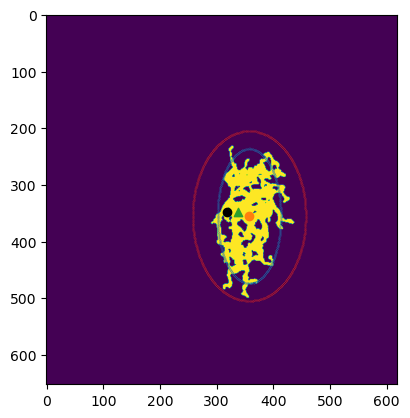

T4-03_D.tif 0.5170995194979224


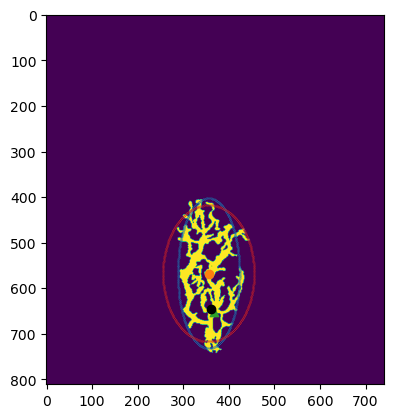

T4-04_B.tif 0.7354744138039927


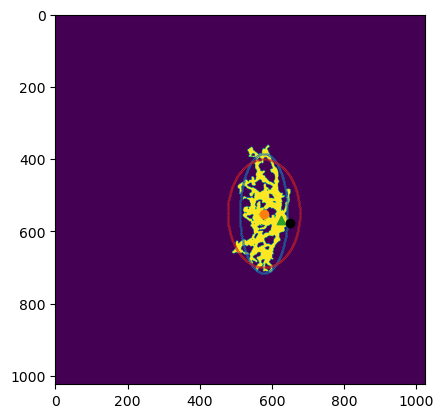

T4-05_D.tif 0.6118746204272958


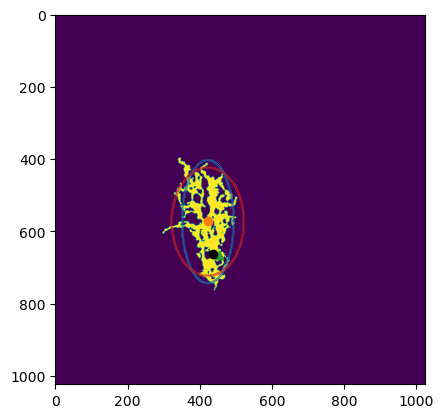

T4-06_D.tif 0.48705608207783324


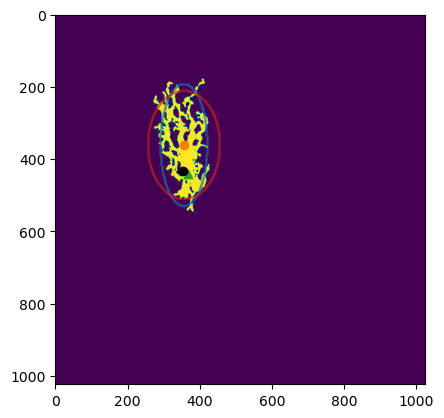

T4-11_B.tif 0.8751568040543978


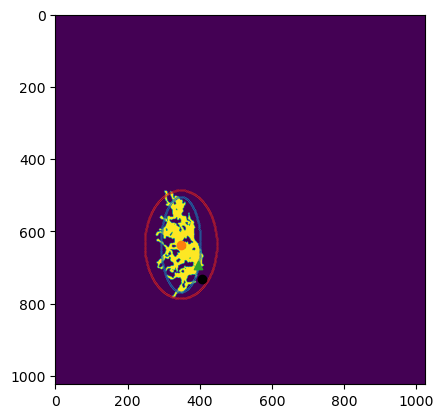

T4-12_C.tif 0.31719896409349035


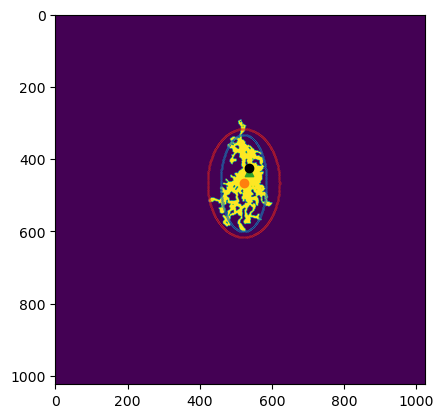

T4-13_B.tif 0.8124474885230069


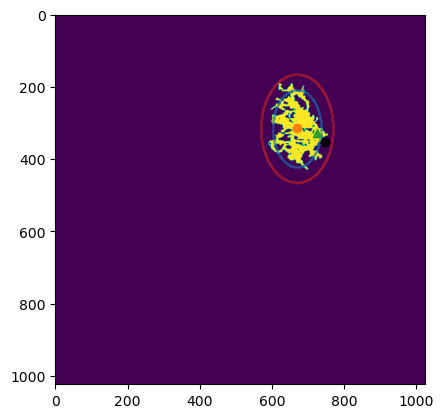

T4-15_A.tif 0.7228906497371732


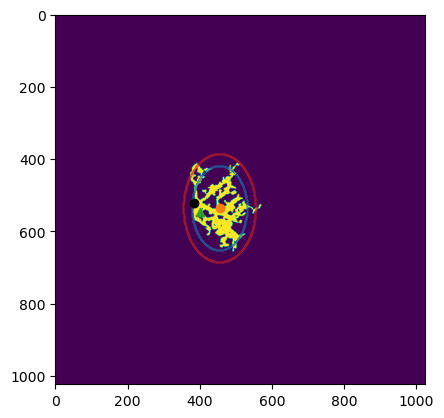

T4-16_C.tif 0.35802568002378043


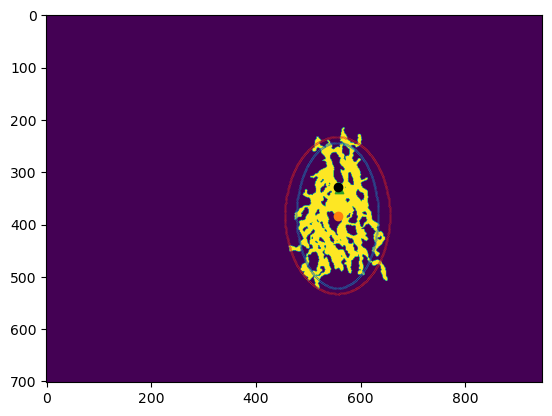

T4-18_C.tif 0.5799114795511131


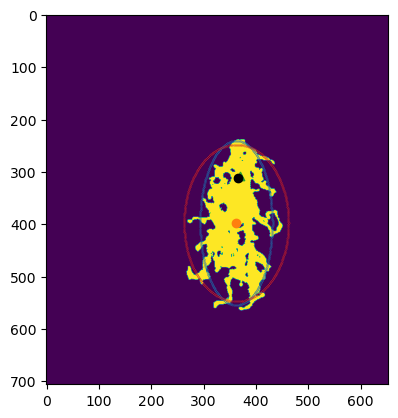

T4-19_D.tif 0.6965563653583521


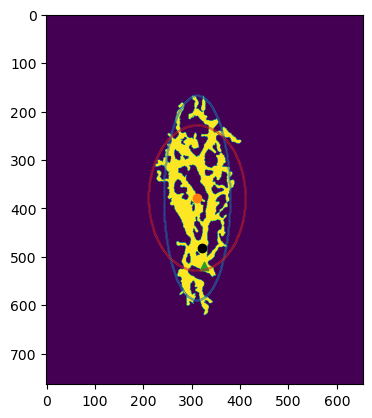

T4-21_B.tif 0.8194296985465529


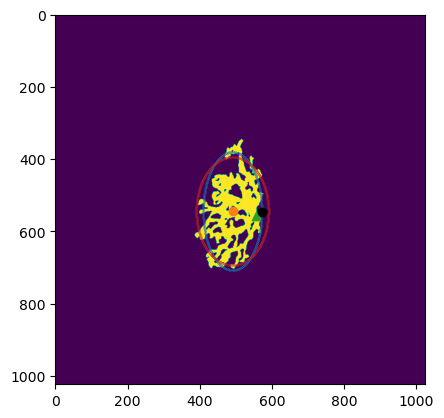

T4-24_B.tif 0.7512028539664891


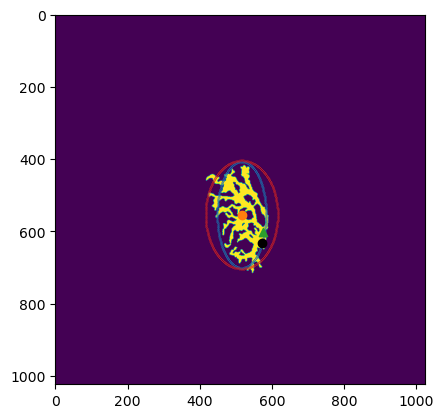

T4-25_A.tif 0.6799904846260142


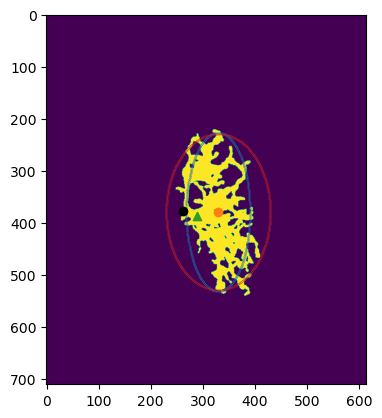

T4-26_A.tif 0.3626259293558788


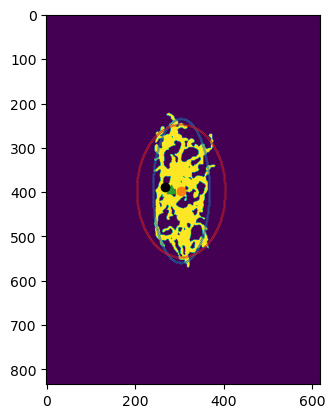

T4-28_B.tif 0.6433911989383836


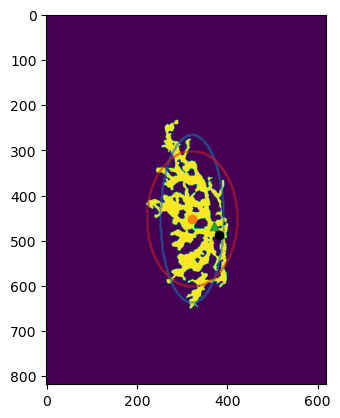

T4-30_C.tif 0.39831374625094906


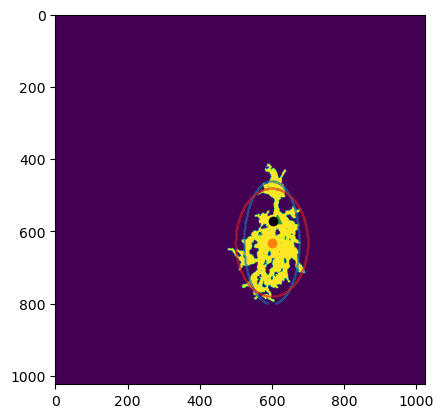

T4-31_C.tif 0.2920565006339766


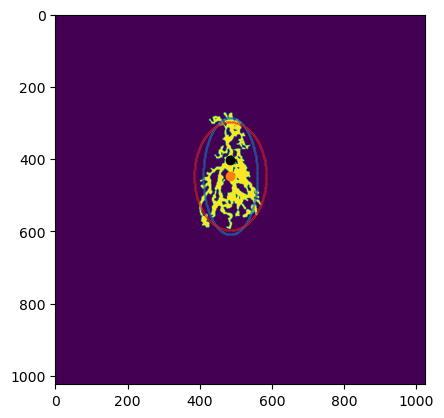

T4-32_C.tif 0.3872716096261811


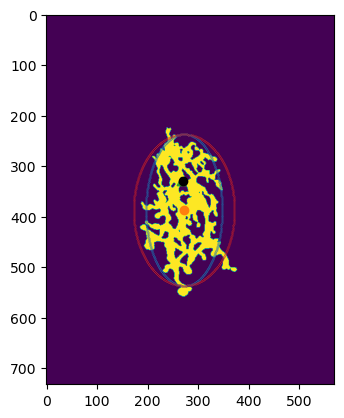

T4-35_A.tif 0.5124606215443575


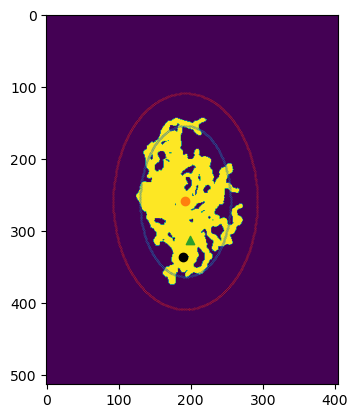

T4-36_B.tif 0.7411677106684265


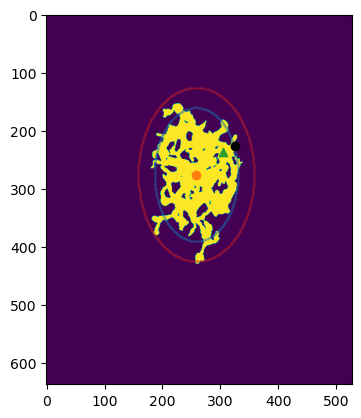

T4-37_D.tif 0.42944306389475456


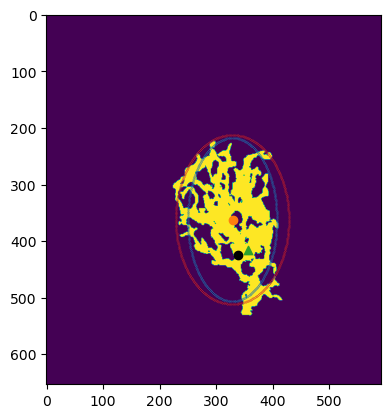

T4-40_A.tif 0.5907402662854401


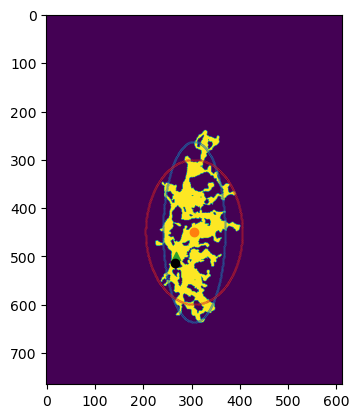

T4-42_C.tif 0.45747576380725447


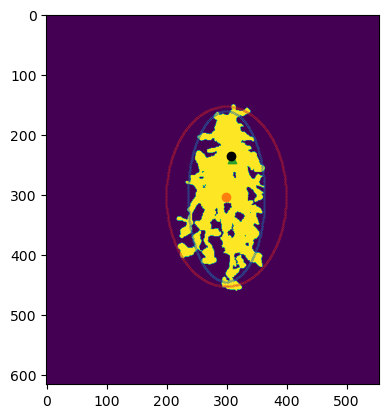

T4-43_A.tif 0.5825525447935943


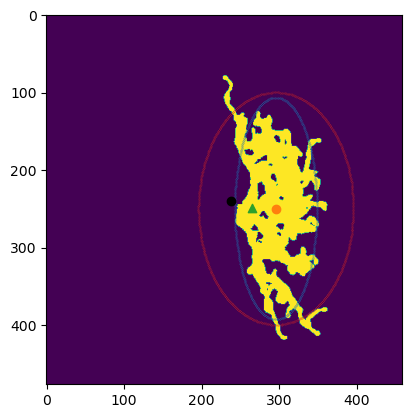

T4-44_D.tif 0.5357343406473662


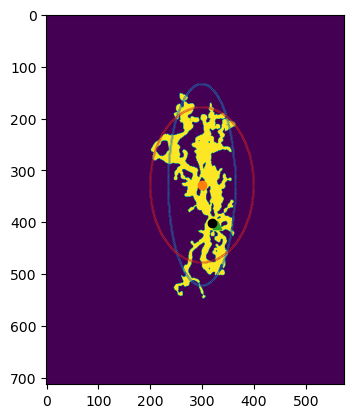

T4-47_C.tif 0.47288220045659535


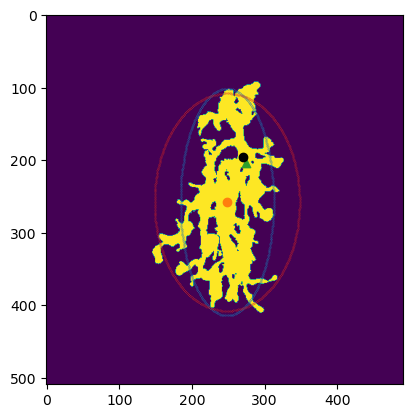

In [40]:
Y,X = 800, 800
results_cols = ['neuron','subtype','ratio', 'y', 'x']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])[1:]
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    img_region = regionprops(img_2d)[0]
    img_center = img_region.centroid
    theta = img_region.orientation
    major_1, minor_1 = img_region.axis_major_length, img_region.axis_minor_length
    # EP_new = (entry_point[0]-img_center[0], entry_point[1]-img_center[1])
    # theta = 0
    y=entry_point[0] - img_center[0]
    x=entry_point[1] - img_center[1]
    # x_ori=img_center[1]
    x_ori = 0
    # y_ori=img_center[0]
    y_ori = 0
    a_ori=major_1/2
    b_ori=minor_1/2 #major and minor of ellispe1
    # x1=img_center[1]
    # y1=img_center[0] #center of ellipse2 (ref)
    x1, y1 = 0, 0
    a1=150
    b1=100 

    p1 = (y-y_ori,x-x_ori)
    p1_theta = np.arctan2(*p1)+theta
    p1_dist = np.linalg.norm(p1)
    # print(np.rad2deg(p1_theta))

    # find the coordinates and distance of edge point on ellipse1 that has the same angle/p1_theta
    edge1_x = (x/abs(x)) * (a_ori*b_ori/np.sqrt((a_ori**2+b_ori**2*np.tan(p1_theta)**2))+x_ori)
    edge1_y = (y/abs(y)) * (np.sqrt((1- (edge1_x/b_ori)**2))*a_ori+y_ori)
    edge1_dist = np.linalg.norm((edge1_y-y_ori,edge1_x-x_ori))
    # print(edge1_dist)

    # find the coordinates and distance of edge point on ellipse2 that has the same angle/p1_theta
    edge2_x = (x/abs(x)) * (a1*b1/np.sqrt((a1**2+b1**2*np.tan(p1_theta)**2))+x1)
    edge2_y = (y/abs(y)) * (np.sqrt((1- (edge2_x/b1)**2))*a1+y1)
    # print(edge2_y)

    edge2_dist = np.linalg.norm((edge2_y-y1,edge2_x-x1))

    ratio = p1_dist/edge1_dist
    dist = edge2_dist * ratio
    print(neu_file, ratio)

    # find coordinates of the point in ellipse2
    x_f = dist*np.cos(p1_theta)+x1
    y_f = dist*np.sin(p1_theta)+y1



    # y_f,x_f, ratio = analysis.transform_point2(theta=theta,y=entry_point[0], x=entry_point[1], 
    #                                         x0=img_center[1], y0=img_center[0], #center of ellipse1 
    #                                         a0=major_1, b0=minor_1, #major and minor of ellispe1
    #                                         x1=img_center[1], y1=img_center[0], #center of ellipse2 (ref)
    #                                         a1=100, b1=60) # major and minor of ellipse2)

    # Drawing ellipse1
    # Y,X = 500, 500
    x0 = img_center[1]; a = minor_1/2  # x center, half width                                       
    y0 = img_center[0]; b = major_1/2  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.imshow(img_2d)
    plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
    plt.scatter(img_center[1],img_center[0])
    # plt.scatter(EP_new[1]+img_center[1],EP_new[0]+img_center[1], marker='^')
    plt.scatter(entry_point[1],entry_point[0], marker='^')
    # plt.scatter(edge1_x+img_center[1],edge1_y+img_center[0], marker='^', c='k')


    a = b1  # x center, half width                                       
    b = a1 # y center, half height 
    X1 = np.linspace(0, X,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
    # plt.scatter(edge2_x+img_center[1],edge2_y+img_center[0])
    plt.scatter(x_f+img_center[1],y_f+img_center[0], c='k')
    plt.show()

    results_df.loc[neuron_n] = [neuron_n, subtype, ratio,y_f, x_f]



    

    

<AxesSubplot:xlabel='x', ylabel='y'>

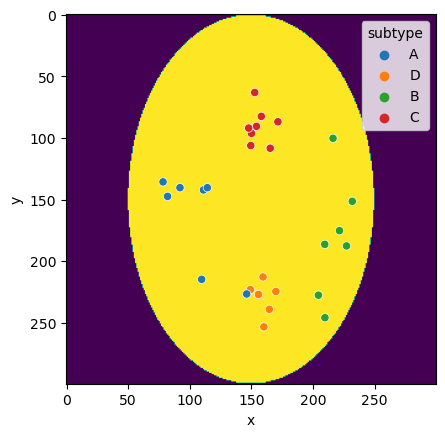

In [36]:
X, Y = 300, 300
x0 = 150; a = 100  # x center, half width                                       
y0 = 150; b = 150  # y center, half height 
X1 = np.linspace(0, Y,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)
contour1 = find_contours(ellipse)[0]

# plt.scatter(contour1[:,1], contour1[:,0])


plt.imshow(ellipse)

Colors = {'A':'b','B':'g','C':'orange','D':'r'}
import seaborn as sns
results_df2 = results_df.copy()
results_df2['x'] = results_df.x+x0
results_df2['y'] = results_df.y+y0
sns.scatterplot(data=results_df2,x='x',y='y',hue='subtype')

<AxesSubplot:xlabel='subtype', ylabel='ratio'>

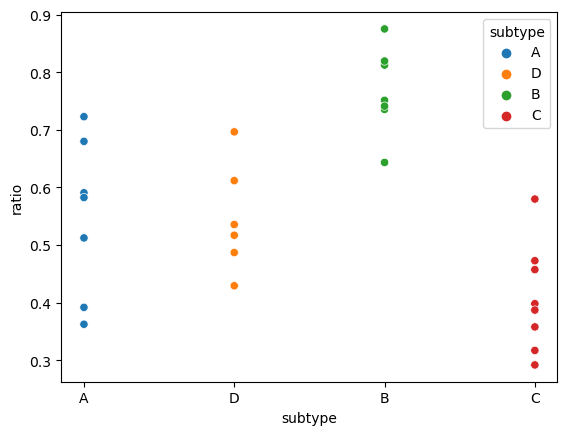

In [37]:
sns.scatterplot(data=results_df2,x='subtype',y='ratio',hue='subtype')

In [38]:
results_df

neuron subtype     ratio           y          x
T4-02  T4-02       A  0.391936   -7.795146 -38.847568
T4-03  T4-03       D  0.517100   77.070426   5.829710
T4-04  T4-04       B  0.735474   25.286219  71.589465
T4-05  T4-05       D  0.611875   89.112941  14.646519
T4-06  T4-06       D  0.487056   73.049227  -0.772295
T4-11  T4-11       B  0.875157   95.910818  59.754506
T4-12  T4-12       C  0.317199  -41.644139  15.342132
T4-13  T4-13       B  0.812447   37.636624  77.273196
T4-15  T4-15       A  0.722891  -14.336449 -71.654453
T4-16  T4-16       C  0.358026  -53.703399   0.147081
T4-18  T4-18       C  0.579911  -86.888359   2.757047
T4-19  T4-19       D  0.696556  103.356309  10.203828
T4-21  T4-21       B  0.819430    1.432815  81.937402
T4-24  T4-24       B  0.751203   77.627682  54.450066
T4-25  T4-25       A  0.679990   -2.568217 -67.977490
T4-26  T4-26       A  0.362626   -9.613950 -35.691687
T4-28  T4-28       B  0.643391   36.369525  59.595611
T4-30  T4-30       C  0.398314  -59.418174   4.173570
T4-31  T4-31       C  0.292057  -43.803505  -0.439912
T4-32  T4-32       C  0.387272  -58.003441  -2.122379
T4-35  T4-35       A  0.512461   76.659238  -3.784105
T4-36  T4-36       B  0.741168  -49.709360  66.295282
T4-37  T4-37       D  0.429443   62.823752   9.490496
T4-40  T4-40       A  0.590740   64.771757 -40.312865
T4-42  T4-42       C  0.457476  -67.532592   8.116943
T4-43  T4-43       A  0.582553   -9.603110 -57.902402
T4-44  T4-44       D  0.535734   74.606581  19.906582
T4-47  T4-47       C  0.472882  -63.112117  21.584522

In [19]:
ratio

0.5170995194979224

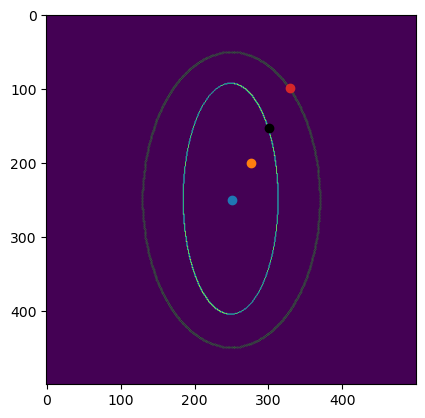

In [8]:
theta=0
y_p= -50
x_p= 26
x0=0
y0=0 #center of ellipse1 
a0=major_1/2
b0=minor_1/2
x1=0
y1=0 #center of ellipse2 (ref)
a1=200
b1=120

# y_p=entry_point[0] - img_center[0]
# x_p=entry_point[1] - img_center[1]
# # x_ori=img_center[1]
# x_ori = 0
# # y_ori=img_center[0]
# y_ori = 0
# # a_ori= 150
# # b_ori= 60 #major and minor of ellispe1
# x1=img_center[1]
# y1=img_center[0] #center of ellipse2 (ref)
# a1=150
# b1=100 


p1 = (y_p-y0, x_p-x0)
p1_theta = np.arctan2(*p1)+theta
p1_dist = np.linalg.norm(p1)

# find the coordinates and distance of edge point on ellipse1 that has the same angle/p1_theta
edge1_x = (x_p/abs(x_p)) * (a0*b0/np.sqrt((a0**2+b0**2*np.tan(p1_theta)**2))+x0)
# edge1_y = edge1_x*np.tan(p1_theta)
edge1_y = (y_p/abs(y_p)) * (np.sqrt(1- (edge1_x/b0)**2)*a0+y0)

# edge1_y = y0-int(np.sqrt((np.tan(p1_theta)*(edge1_x-x0))**2))
edge1_dist = np.linalg.norm((edge1_y-y0,edge1_x-x0))

# find the coordinates and distance of edge point on ellipse2 that has the same angle/p1_theta
edge2_x = (x_p/abs(x_p)) * (a1*b1/np.sqrt((a1**2+b1**2*np.tan(p1_theta)**2))+x1)
edge2_y = (y_p/abs(y_p)) * (np.sqrt(1- (edge2_x/b1)**2)*a1+y1)
edge2_dist = np.linalg.norm((edge2_y-y1,edge2_x-x1))

# Drawing ellipse1
X,Y = 500,500

x0=X/2
y0=Y/2 #center of ellipse1 
a = b0  # x center, half width                                       
b = a0 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((Y,X))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)
plt.scatter(X/2,Y/2)
plt.scatter(X/2+x_p,Y/2+y_p)
plt.scatter(X/2+edge1_x,Y/2+edge1_y, c='k')

x0=X/2
y0=Y/2 #center of ellipse1 
a = b1  # x center, half width                                       
b = a1 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
plt.scatter(X/2+edge2_x,Y/2+edge2_y)

plt.show()

In [58]:
major_1, b0

(312.6748324066602, 64.2096125974759)

In [19]:
edge1_y, y_ori ,edge1_x, x_ori

(303.73607215696205, 257.9374601774249, 292.11468922575335, 248.62191834534138)

In [8]:
np.sqrt(1- (edge1_x/b_ori)**2)

/tmp/ipykernel_768716/2857924565.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1- (edge1_x/b_ori)**2)


nan

In [11]:
(1- (edge1_x/b_ori)**2)

-5.635356183063244

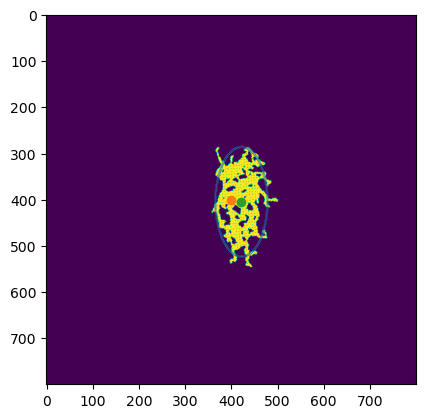

nan 21.763492125030385 nan


/home/tli_project/Desktop/TLI_preprocessing/Github_repo/TLI/pipeline/TLI_analysis/utils/analysis.py:374: RuntimeWarning: invalid value encountered in sqrt
  edge1_y = np.sqrt(1- (edge1_x/b0)**2)*a0+y0
/home/tli_project/Desktop/TLI_preprocessing/Github_repo/TLI/pipeline/TLI_analysis/utils/analysis.py:379: RuntimeWarning: invalid value encountered in sqrt
  edge2_y = np.sqrt(1- (edge2_x/b1)**2)*a1+y1


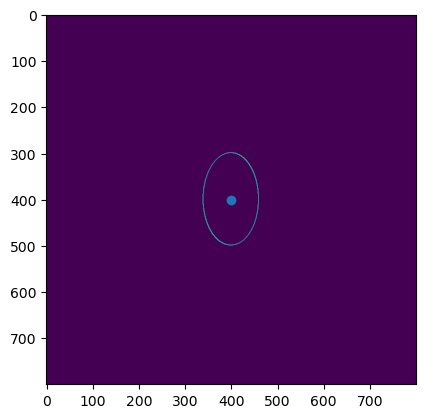

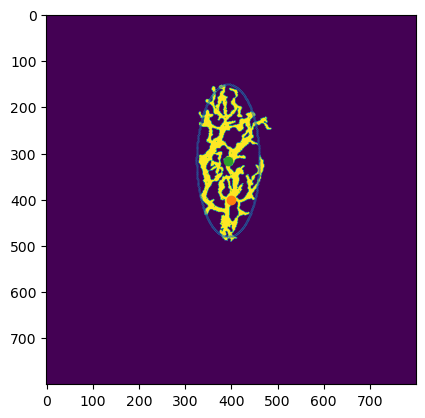

nan 84.70483945045234 nan


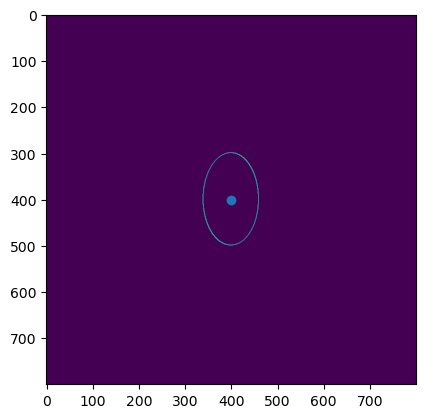

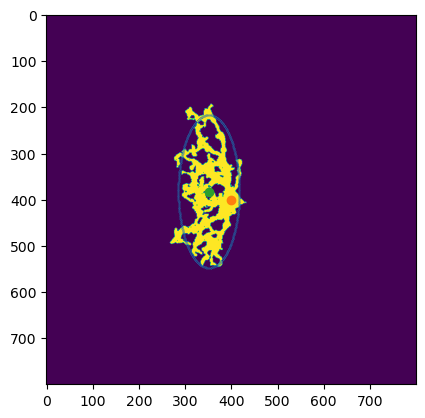

nan 51.43456854931107 nan


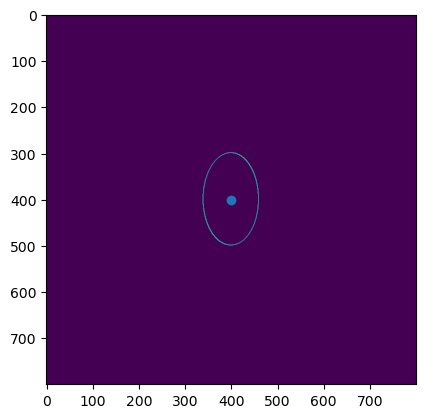

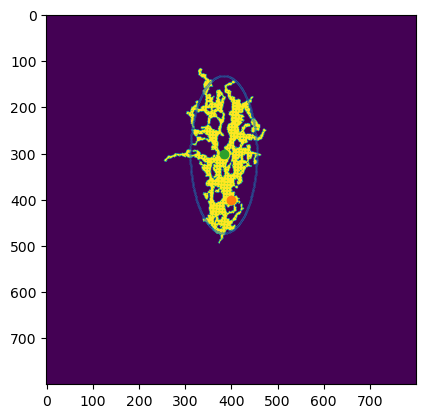

nan 99.2677136151981 nan


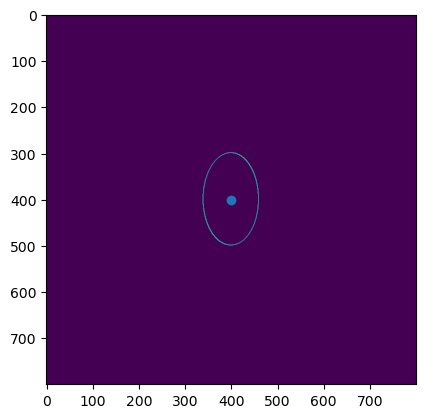

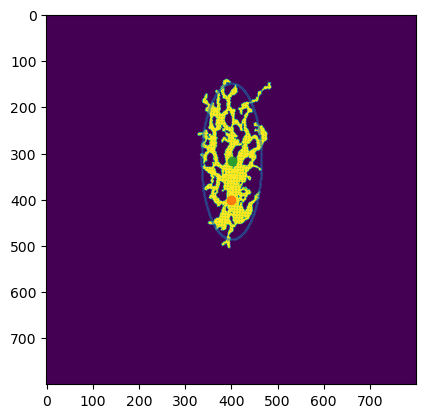

nan 82.89155924052488 nan


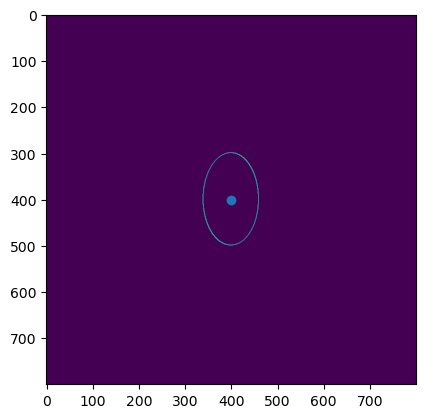

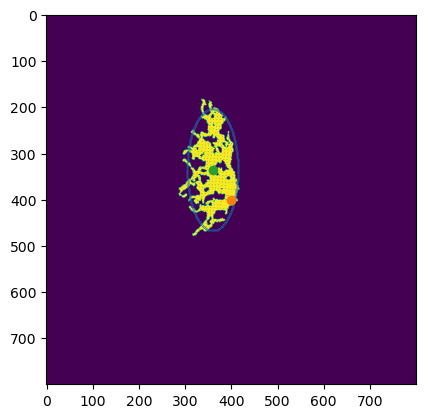

nan 75.96753565462681 nan


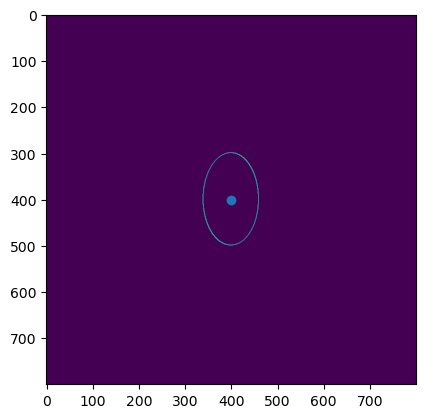

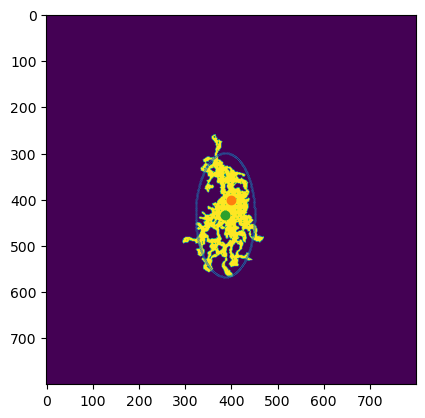

nan 35.628571628236564 nan


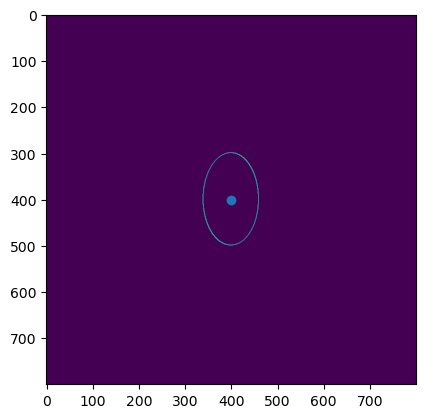

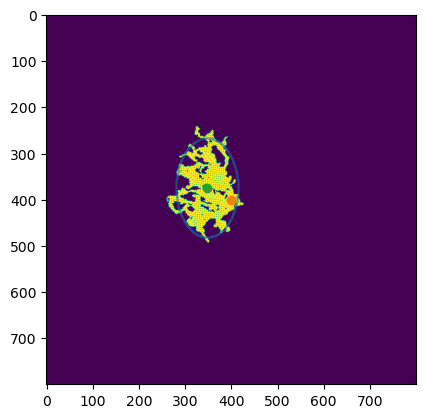

nan 58.472332686841426 nan


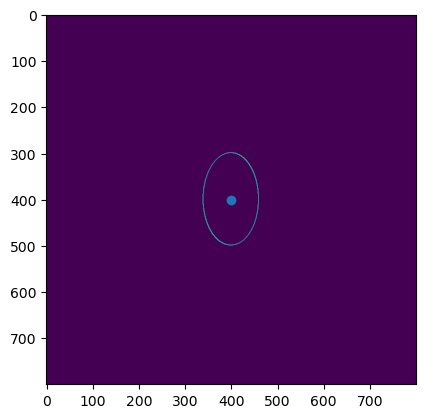

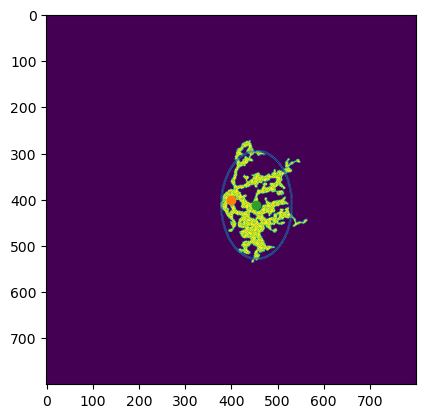

nan 55.21508965061827 nan


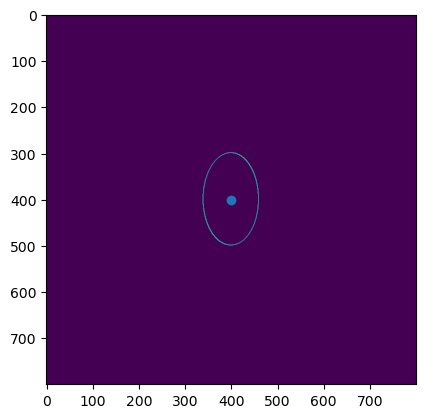

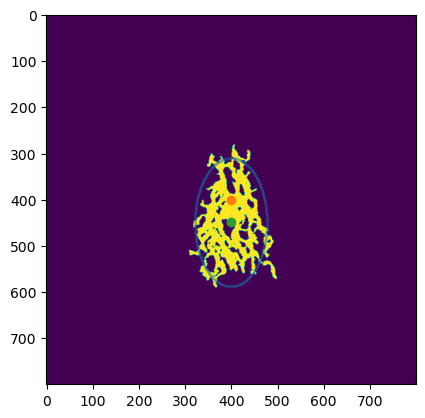

nan 49.31706705546611 nan


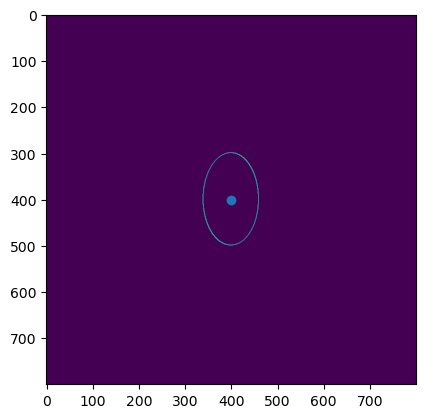

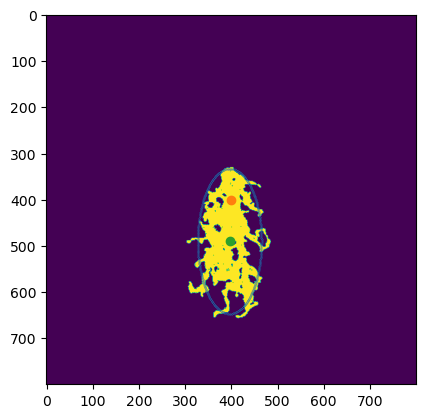

nan 90.38710265695933 nan


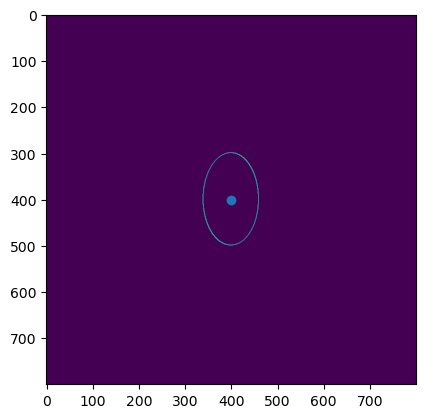

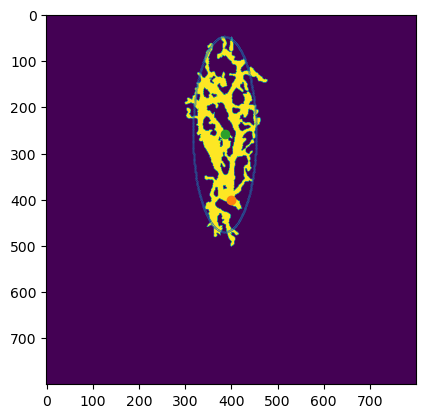

nan 142.21956919510868 nan


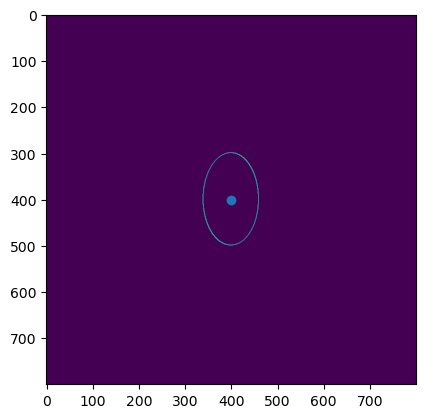

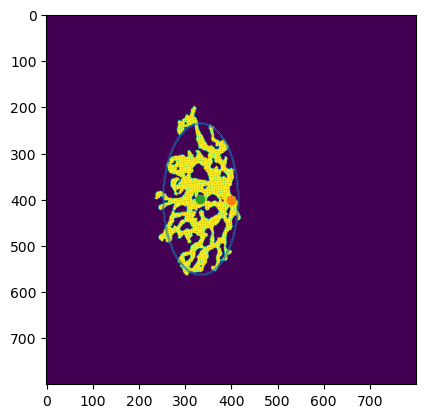

nan 67.01424866548075 nan


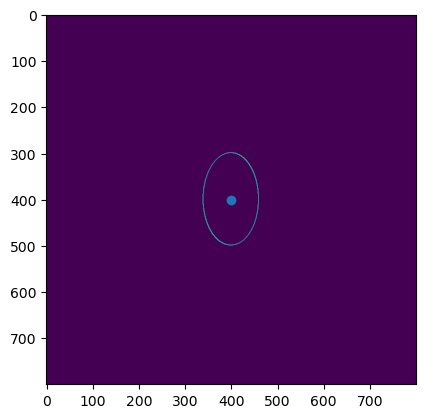

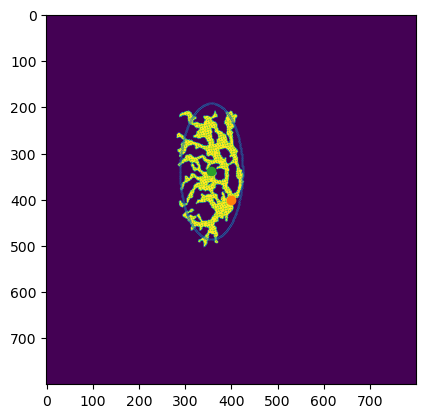

nan 74.854917464296 nan


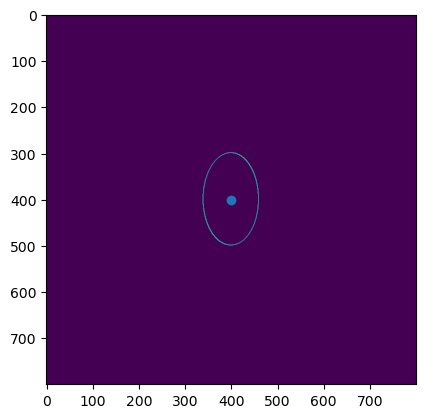

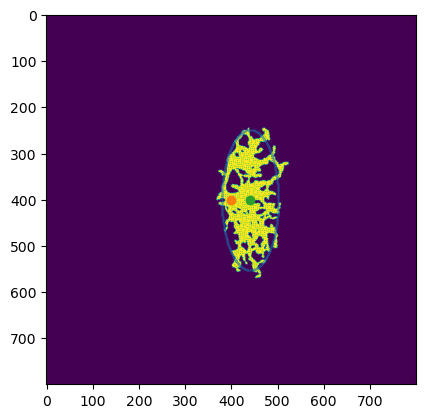

nan 41.136205718676315 nan


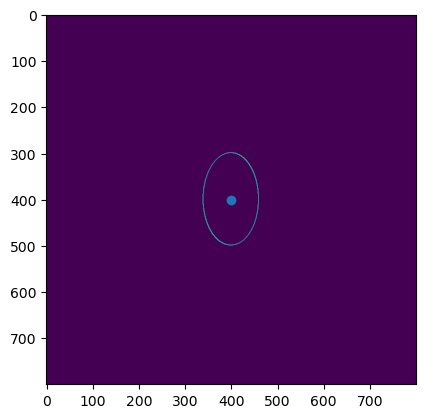

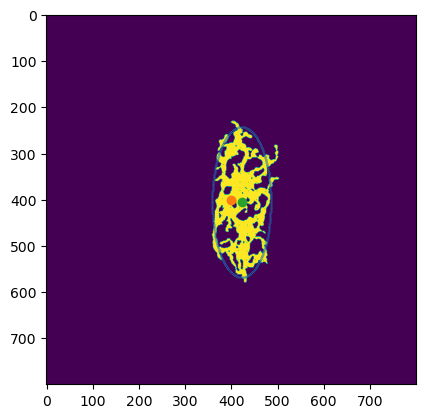

nan 23.16742931366697 nan


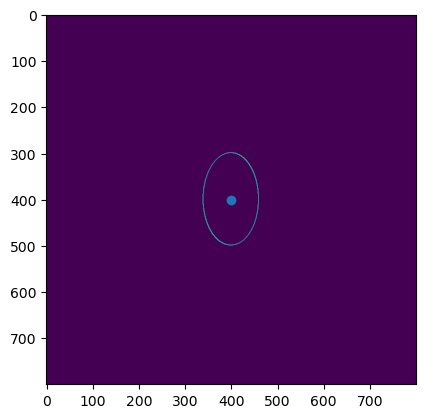

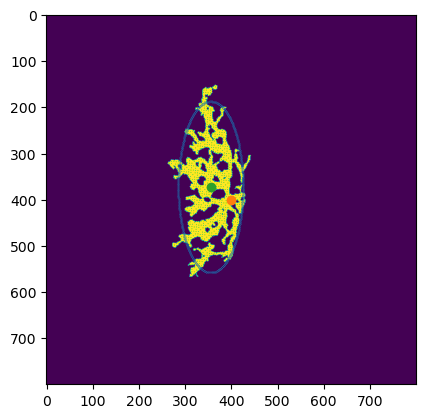

nan 52.019228764391585 nan


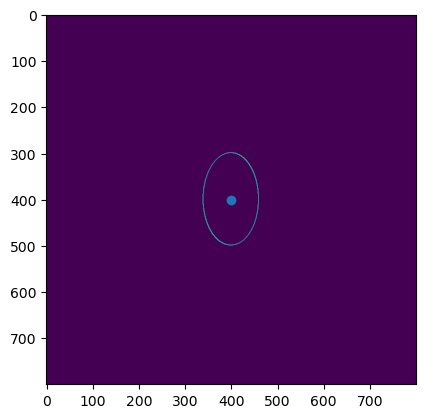

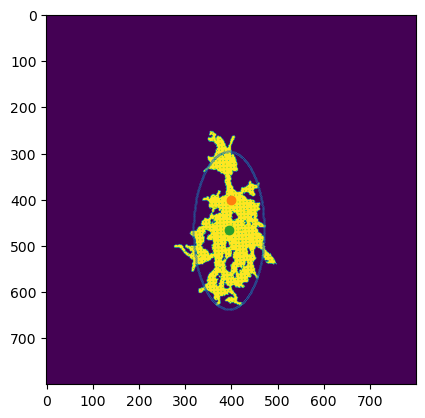

nan 66.80342126718125 nan


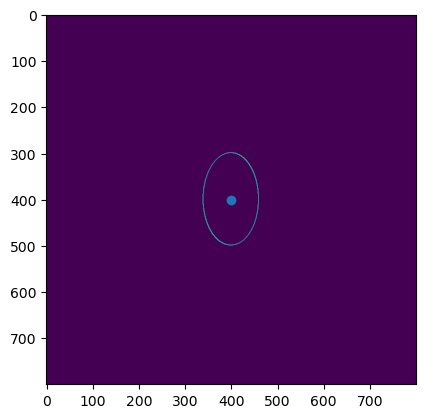

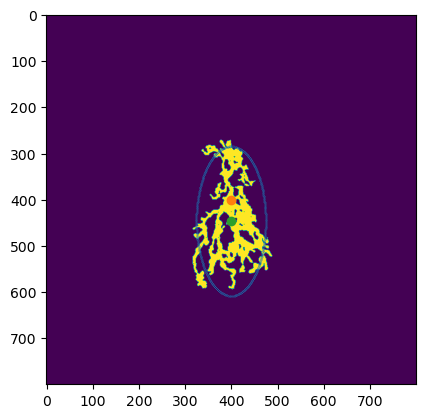

nan 46.75023847453313 nan


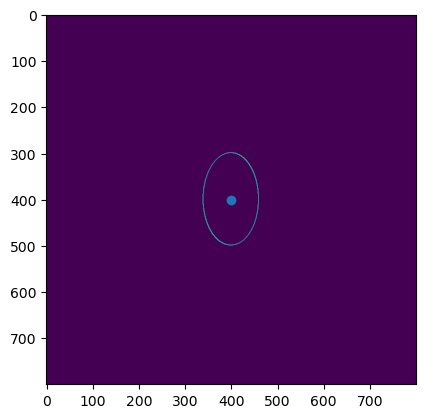

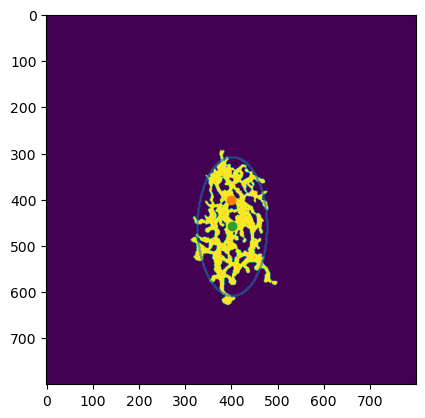

nan 57.55190248144357 nan


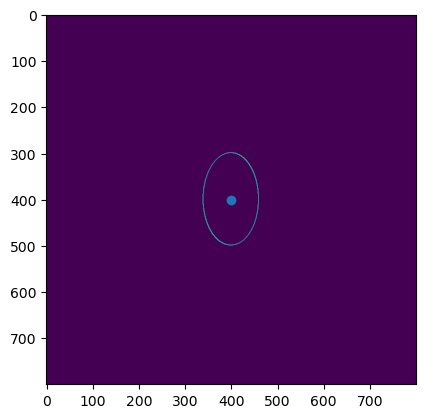

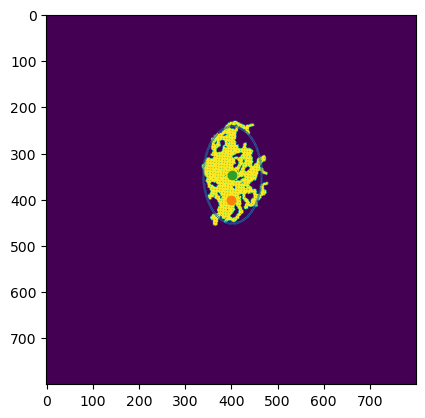

nan 54.184709340796886 nan


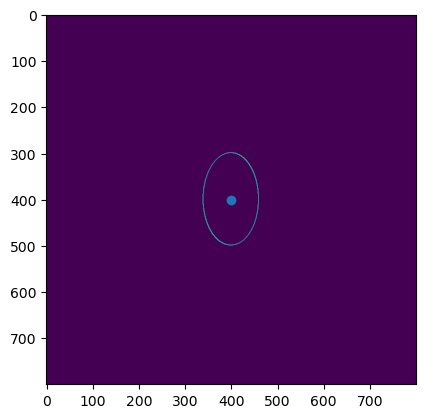

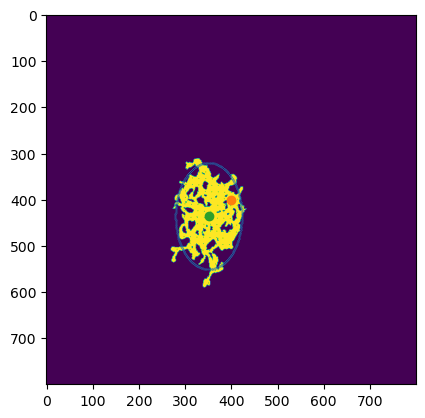

nan 60.496301599901884 nan


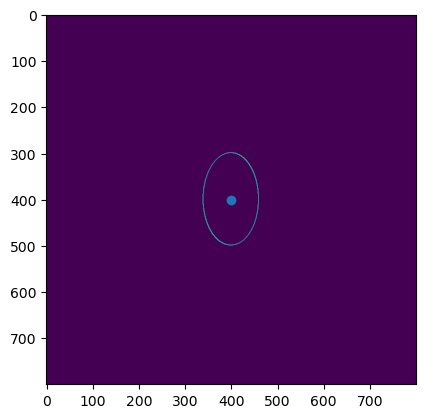

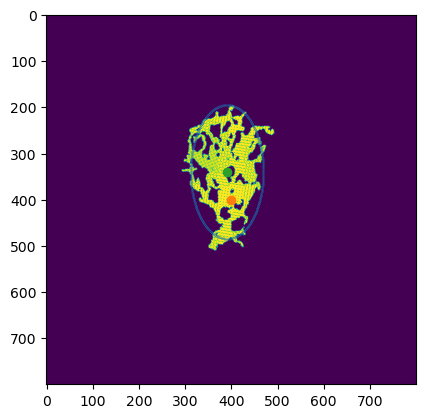

nan 60.684720673357035 nan


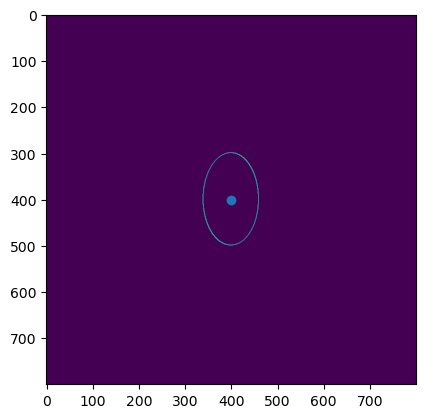

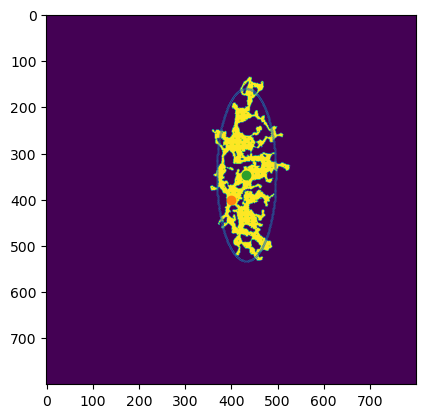

nan 62.9316983471552 nan


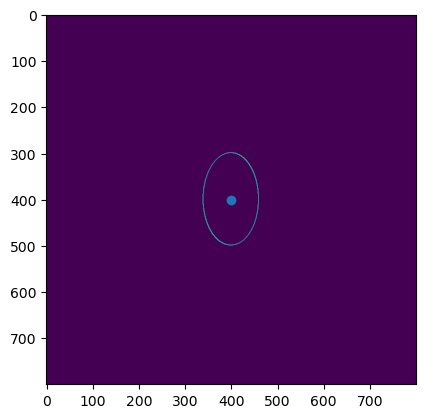

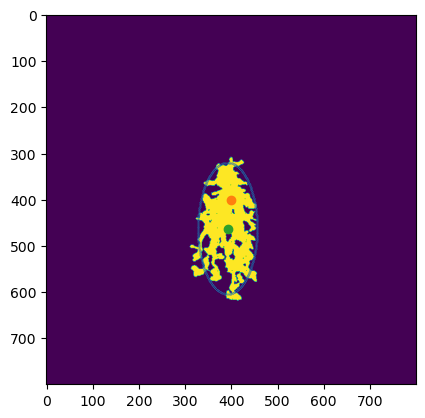

nan 62.9151743938694 nan


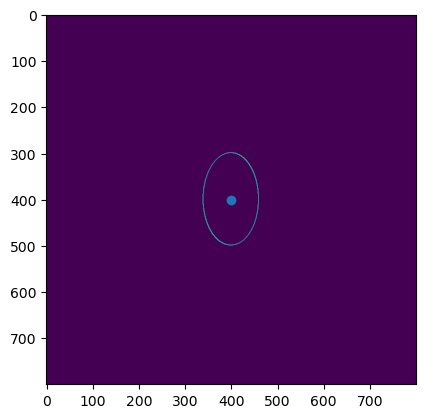

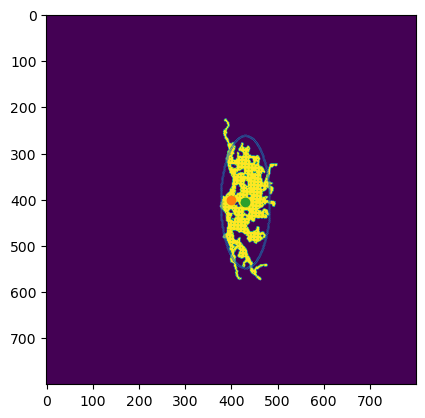

nan 30.652266232713895 nan


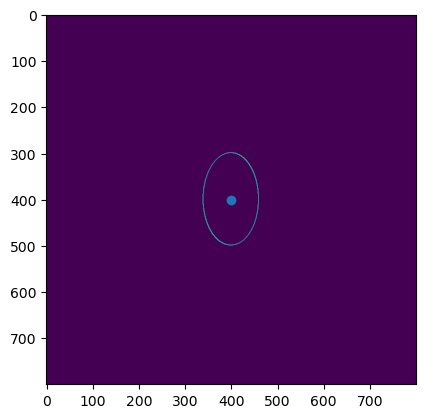

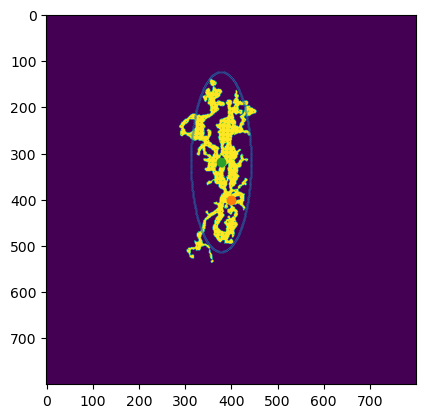

nan 84.81991617052401 nan


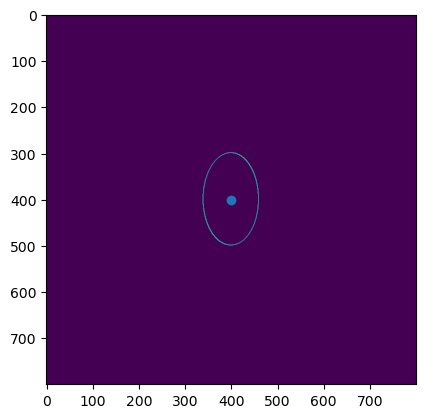

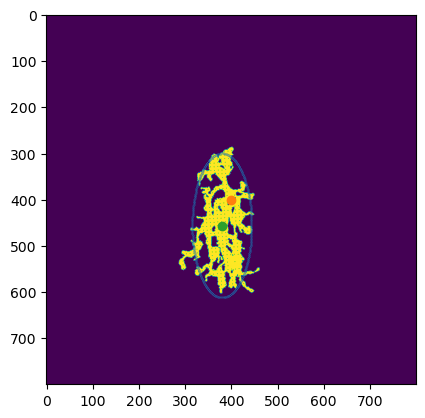

nan 59.78148345030287 nan


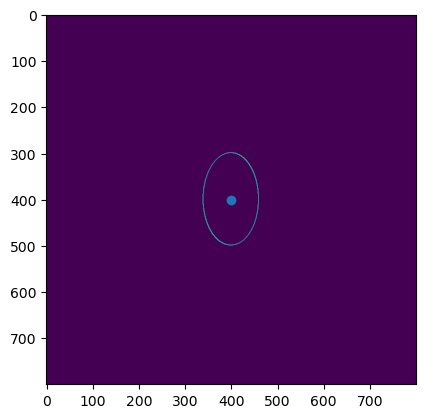

In [28]:
Y,X = 800, 800
results_cols = ['neuron','subtype','ratio']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    # plt.imshow(img_2d)
    # plt.scatter(entry_point[2], entry_point[1])
    # plt.show()

    asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2d,entry_point[1:],plot=False)

    img_transformed = np.zeros((Y,X))
    test = shifted_coor.copy()
    test[:,0]  = test[:,0]+X/2
    test[:,1] = -1*test[:,1]+Y/2
    for i in test:
        x,y = int(i[0]), int(i[1])
        img_transformed[y,x] = 1
    img_transformed = img_transformed.astype('uint8')
    new_region = regionprops(img_transformed)[0]
    new_center = new_region.centroid
    major_1, minor_1 = new_region.axis_major_length, new_region.axis_minor_length

    # Drawing ellipse1
    x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
    y0 = new_center[0]; b = major_1/2  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.imshow(img_transformed)
    plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
    plt.scatter(Y/2,X/2)
    plt.scatter(new_center[1],new_center[0])
    plt.show()

    y_f,x_f, ratio = analysis.transform_point2(theta=0,y=new_center[0], x=new_center[1], 
                                                x0=X/2, y0=Y/2, #center of ellipse1 
                                                a0=major_1, b0=minor_1, #major and minor of ellispe1
                                                x1=X/2, y1=Y/2, #center of ellipse2 (ref)
                                                a1=100, b1=60) # major and minor of ellipse2)
    

        # Drawing ellipse1
    x0 = X/2; a = 60  # x center, half width                                       
    y0 = Y/2; b = 100  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    ellipse = np.zeros((Y,X))
    for i in contour1:
        y,x = int(i[0]), int(i[1])
        ellipse[y,x] = 1
    plt.imshow(ellipse)
    plt.scatter(X/2,Y/2)
    plt.scatter(x_f,y_f)
    plt.show()

    results_df.loc[neuron_n] = [neuron_n, subtype, ratio]

0.19596810325090744 22.334024849106072 113.9676532997349


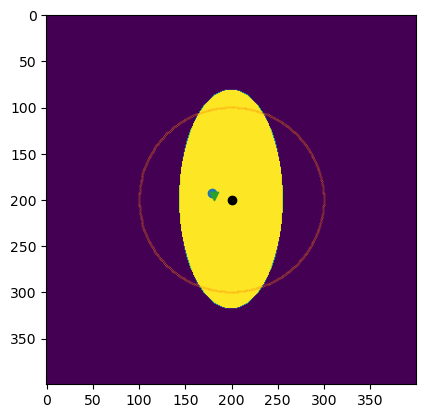

0.2585497597489612 84.15289679920197 325.4804679799749


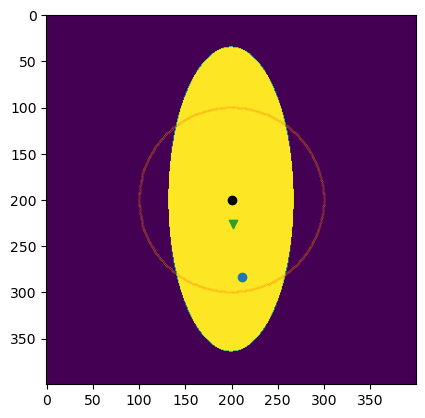

0.36773720690199635 50.80881176885653 138.16608930299867


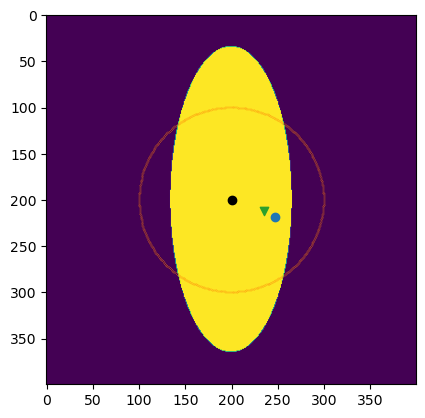

0.3059373102136479 98.60692620843258 322.3108882652186


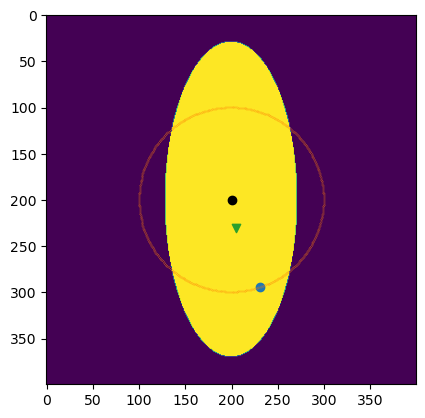

0.24352804103891662 82.37676101552854 338.26396608826025


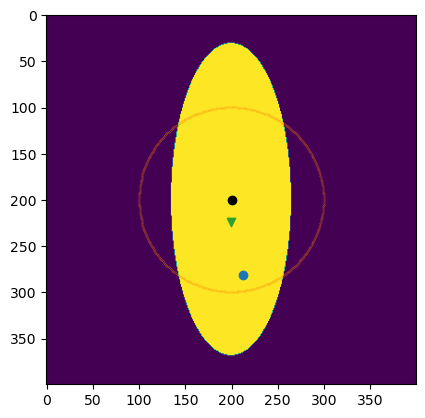

0.4375784020271989 75.38226345552425 172.27144462865573


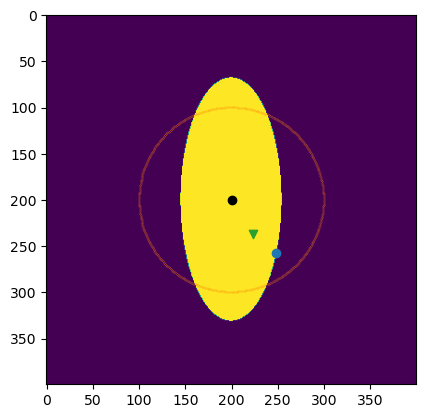

0.15859948204674518 35.89088602401877 226.29888547454644


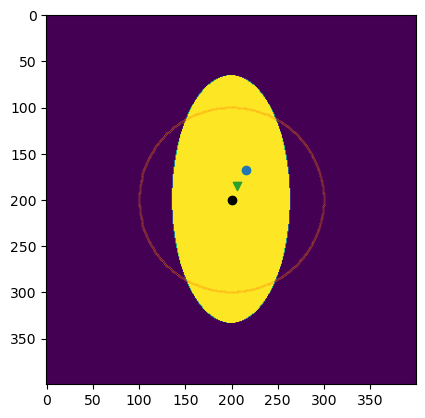

0.4062237442615034 57.792450602623894 142.26753462599282


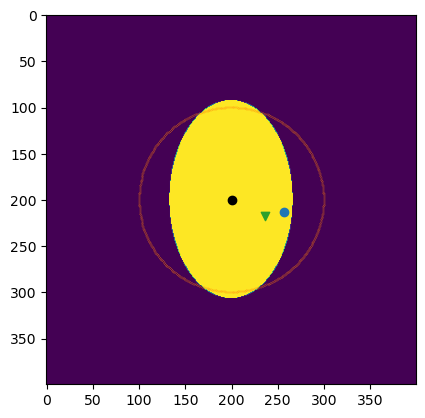

0.3614453248685866 55.75701338206762 154.2612659392942


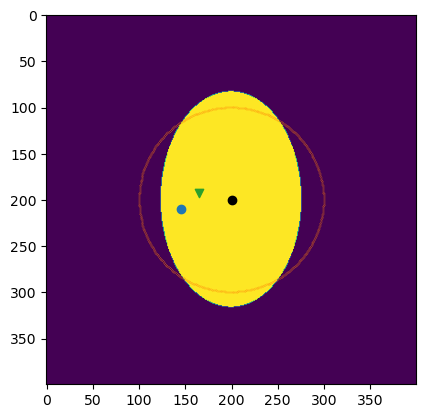

0.17901284001189022 49.817019768481664 278.2874109207628


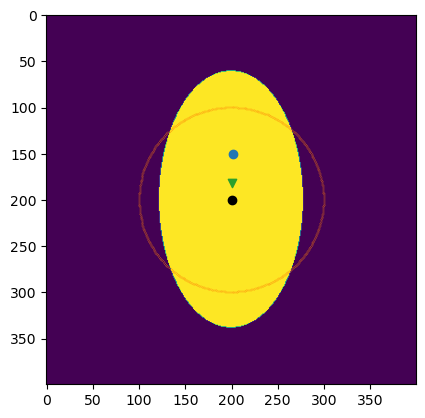

0.28995573977555655 90.90128949307874 313.50056930565296


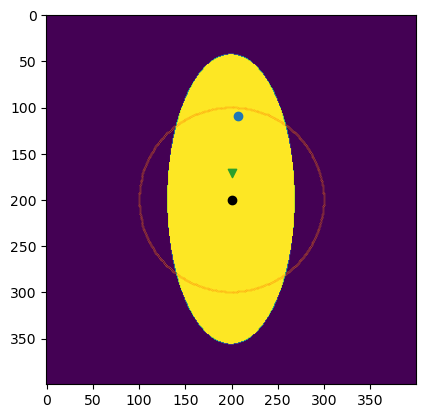

0.34827818267917604 141.64493060934905 406.70055620402826


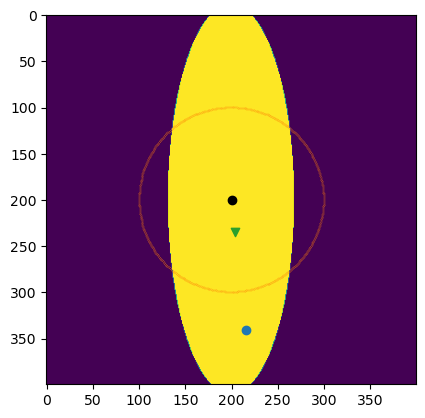

0.40971484927327645 66.51178592810766 162.33677165004298


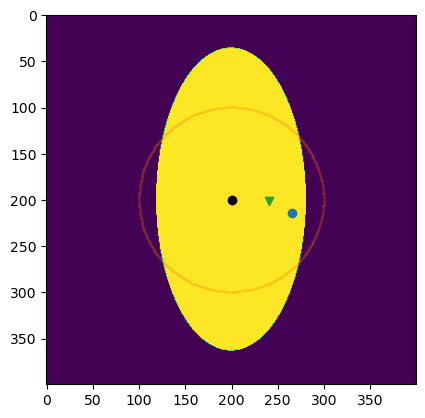

0.37560142698324456 74.09294717351283 197.2648181041604


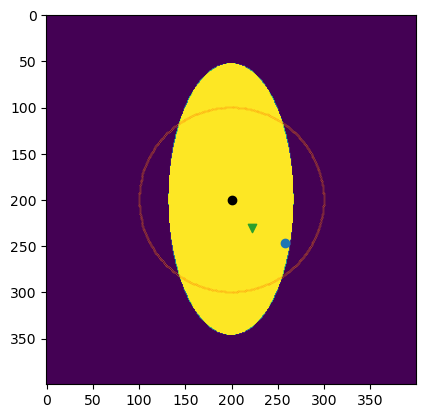

0.3399952423130071 41.636754412620284 122.46275603553468


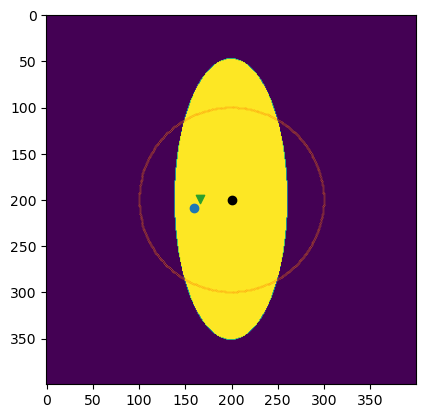

0.1813129646779394 23.7941235960695 131.23233431395414


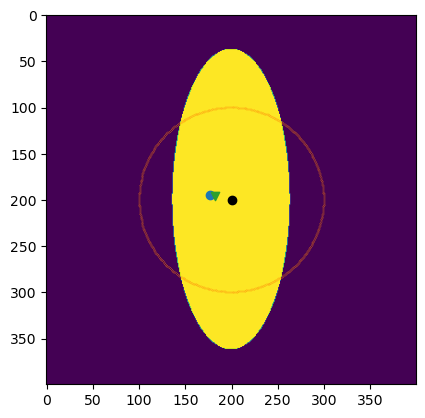

0.3216955994691918 51.34224229178589 159.5988331096299


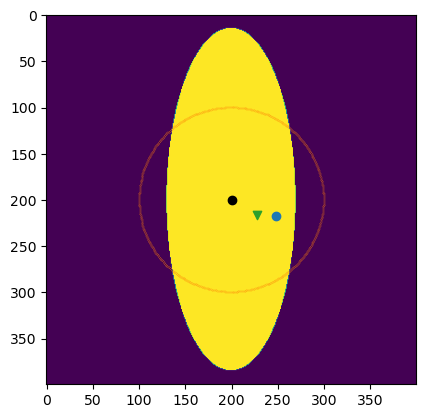

0.19915687312547453 67.29107954923504 337.87977534091794


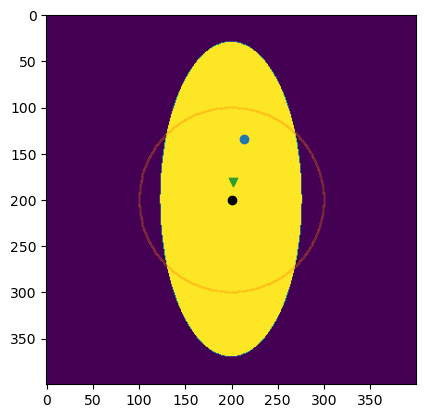

0.1460282503169883 47.255009814135576 323.60183534047405


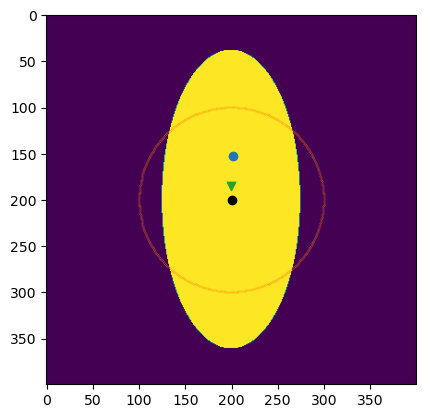

0.19363580481309056 58.08967043329238 299.9944689432008


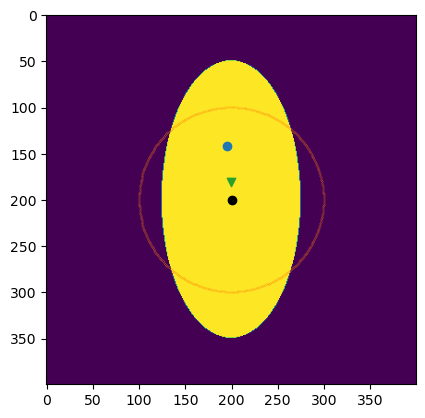

0.2562303107721787 53.680509339865665 209.50101171907974


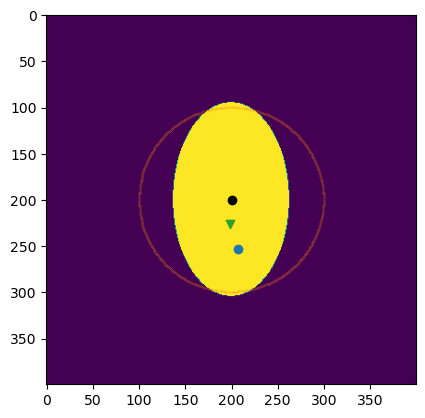

0.37058385533421323 60.388823157046005 162.95589321500256


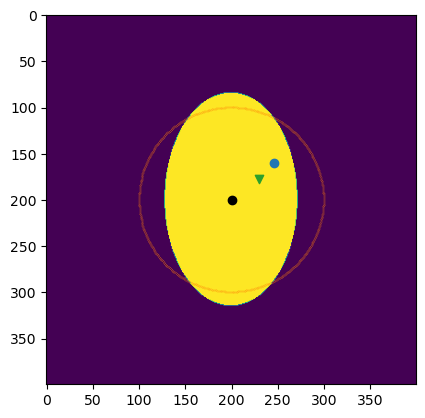

0.21472153194737728 60.50957426103106 281.8048740256771


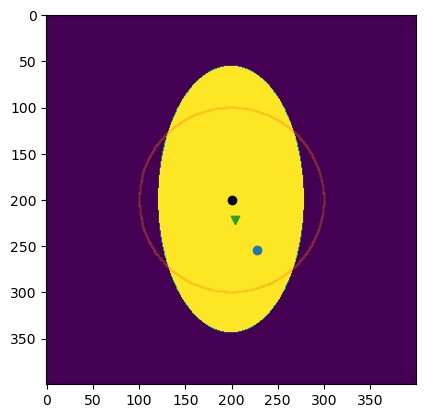

0.29537013314272004 62.768355087752 212.50745435870772


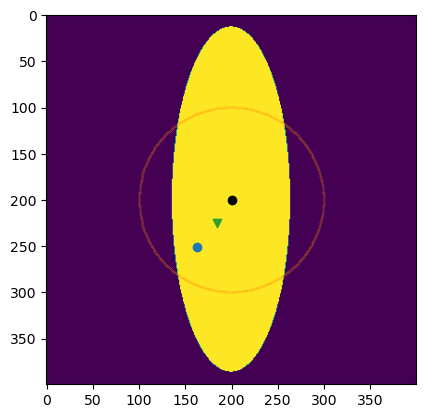

0.22873788190362723 63.3564188149653 276.9826243370518


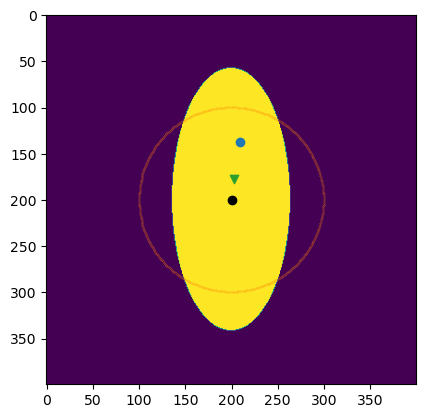

0.29127627239679715 31.21213542852646 107.1564641077495


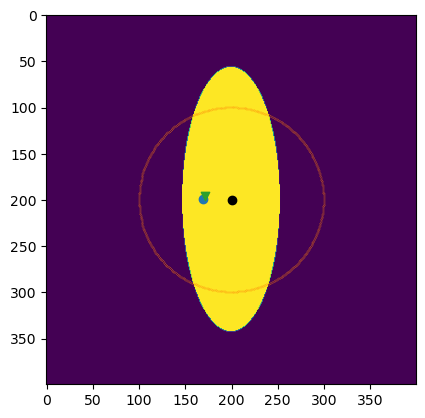

0.2678671703236831 84.27678279350937 314.62154429627077


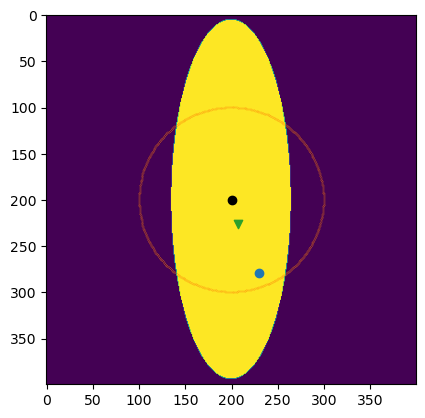

0.23644110022829767 60.042091920344795 253.94101051962053


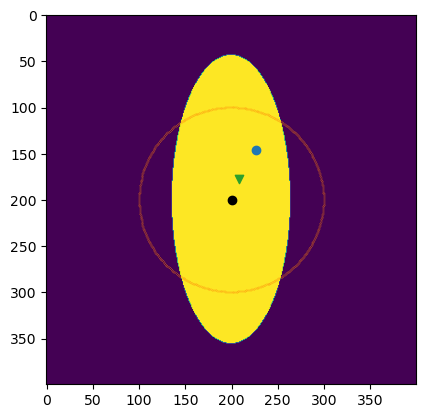

In [18]:
Y,X = 400, 400
results_cols = ['neuron','subtype','ratio', 'y', 'x']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])[1:]
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    img_region = regionprops(img_2d)[0]
    img_center = img_region.centroid
    theta = img_region.orientation
    major_1, minor_1 = img_region.axis_major_length, img_region.axis_minor_length

    EP_new = (entry_point[0]-img_center[0], entry_point[1]-img_center[1])
    y_f,x_f, ratio = analysis.transform_point2(theta=theta,y=EP_new[0], x=EP_new[1], 
                                                x0=0, y0=0, #center of ellipse1 
                                                a0=major_1, b0=minor_1, #major and minor of ellispe1
                                                x1=0, y1=0, #center of ellipse2 (ref)
                                                a1=100, b1=100) # major and minor of ellipse2)
    

    # Drawing ellipse1
    x0 = X/2; a = minor_1/2  # x center, half width                                       
    y0 = Y/2; b = major_1/2  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)
    plt.imshow(ellipse)
    plt.scatter(X/2,Y/2,c='k')
    plt.scatter(X/2+EP_new[1],Y/2+EP_new[0])

    
    # # Drawing ellipse2
    x0=X/2
    y0=Y/2 #center of ellipse1 
    a = 100  # x center, half width                                       
    b = 100 # y center, half height 
    X1 = np.linspace(0, X,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
    plt.scatter(X/2+x_f,Y/2+y_f, marker='v')

    plt.show()







    # plt.imshow(img_2d)
    # plt.scatter(entry_point[2], entry_point[1])
    # plt.show()

    # asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2d,entry_point[1:],plot=False)

    # # shifted_coor = np.argwhere
    # img_transformed = np.zeros((Y,X))
    # test = np.argwhere(img_2d) - entry_point[1:]
    # test[:,0]  = test[:,0]+X/2
    # test[:,1] = test[:,1]+Y/2
    # for i in test:
    #     x,y = int(i[1]), int(i[0])
    #     img_transformed[y,x] = 1
    # img_transformed = img_transformed.astype('uint8')
    # new_region = regionprops(img_transformed)[0]
    # new_center = new_region.centroid
    # theta = new_region.orientation
    # major_1, minor_1 = new_region.axis_major_length, new_region.axis_minor_length

    #     # Drawing ellipse1
    # x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
    # y0 = new_center[0]; b = major_1/2  # y center, half height 
    # X1 = np.linspace(0, Y,X)  # x values of interest
    # Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    # ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    # ellipse = ellipse.astype(int)

    # contour1 = find_contours(ellipse)[0]
    # plt.imshow(img_transformed)
    # plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
    # plt.scatter(Y/2,X/2)
    # plt.scatter(new_center[1],new_center[0])
    # plt.show()

    # EP_new = (-new_center[0], -new_center[1])
    # y_f,x_f, ratio = analysis.transform_point2(theta=theta,y=EP_new[0], x=EP_new[1], 
    #                                             x0=0, y0=0, #center of ellipse1 
    #                                             a0=major_1, b0=minor_1, #major and minor of ellispe1
    #                                             x1=0, y1=0, #center of ellipse2 (ref)
    #                                             a1=100, b1=60) # major and minor of ellipse2)
    

    # # Drawing ellipse1
    # x0 = X/2; a = minor_1/2  # x center, half width                                       
    # y0 = Y/2; b = major_1/2  # y center, half height 
    # X1 = np.linspace(0, Y,X)  # x values of interest
    # Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    # ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    # ellipse = ellipse.astype(int)
    # plt.imshow(ellipse)
    # plt.scatter(X/2,Y/2,c='k')
    # plt.scatter(X/2+EP_new[1],Y/2+EP_new[0])

    
    # # Drawing ellipse2
    # x0=X/2
    # y0=Y/2 #center of ellipse1 
    # a = 60  # x center, half width                                       
    # b = 100 # y center, half height 
    # X1 = np.linspace(0, X,X)  # x values of interest
    # Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    # ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    # ellipse = ellipse.astype(int)

    # contour1 = find_contours(ellipse)[0]
    # plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
    # plt.scatter(X/2+x_f,Y/2+y_f, marker='v')

    # plt.show()
    

In [8]:
EP_new[1],EP_new[0]

(-44.621918345341385, -254.9374601774249)

<AxesSubplot:>

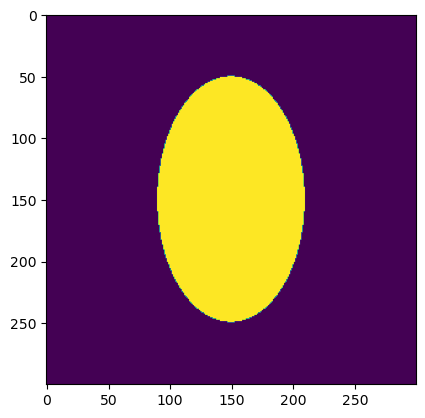

In [548]:
X, Y = 300, 300
x0 = X/2; a = 60  # x center, half width                                       
y0 = Y/2; b = 100  # y center, half height 
X1 = np.linspace(0, Y,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)
plt.imshow(ellipse)

Colors = {'A':'b','B':'g','C':'orange','D':'r'}
import seaborn as sns
sns.scatterplot(data=results_df2,x='x',y='y',hue='subtype')

In [546]:
sns.boxenplot(data=results_df,y='ratio', x='subtype',hue='subtype')

ValueError: min() arg is an empty sequence

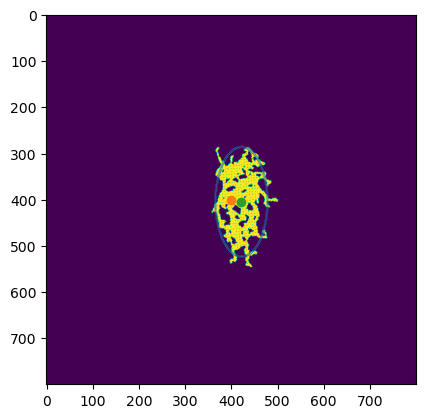

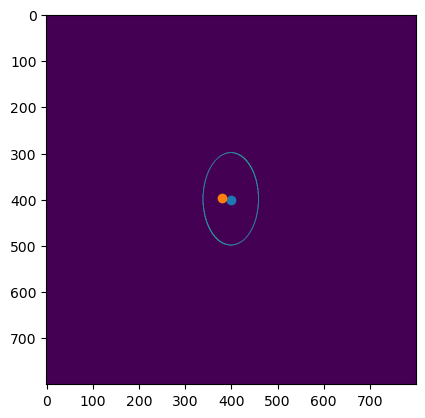

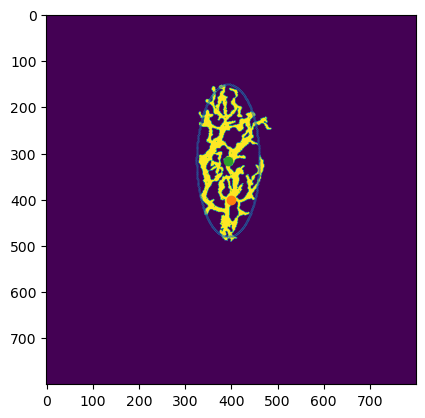

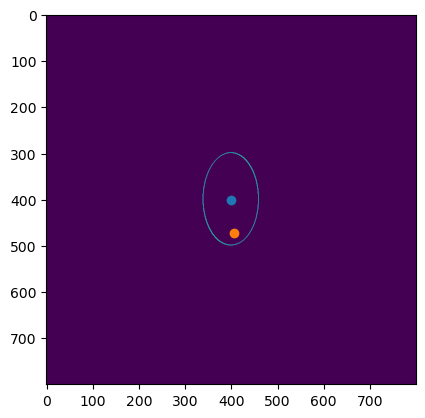

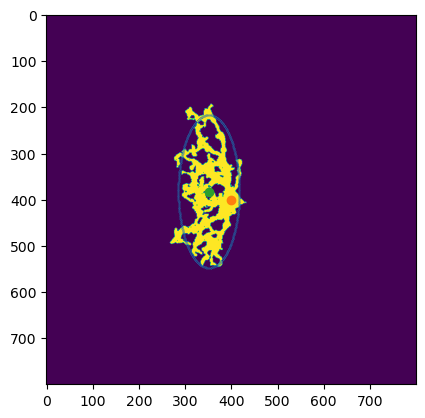

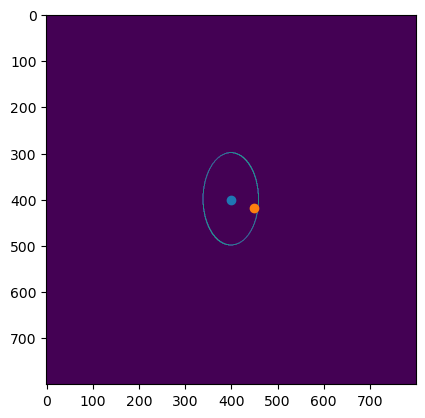

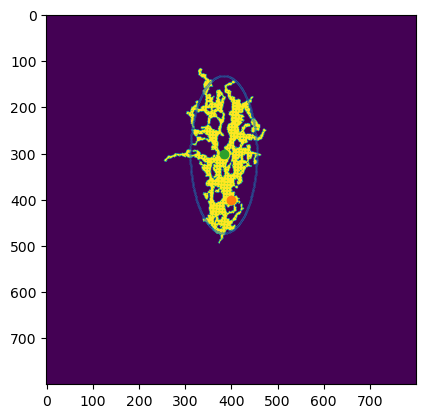

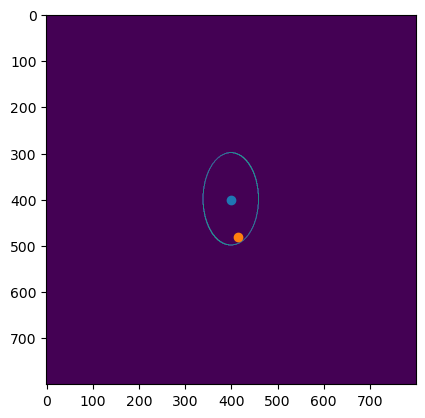

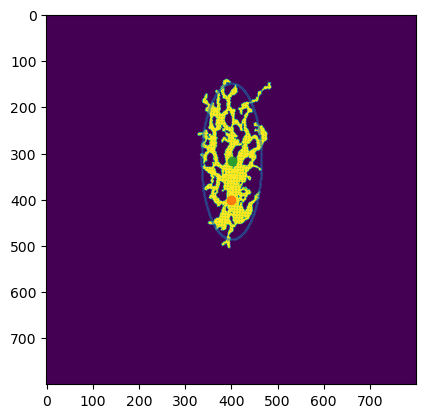

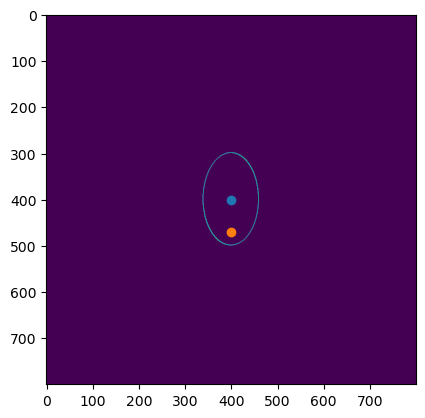

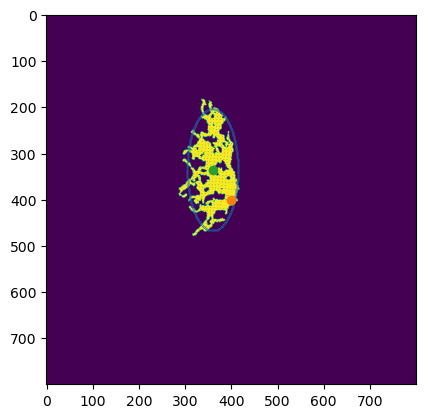

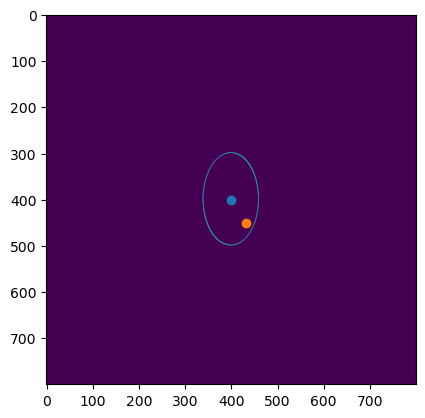

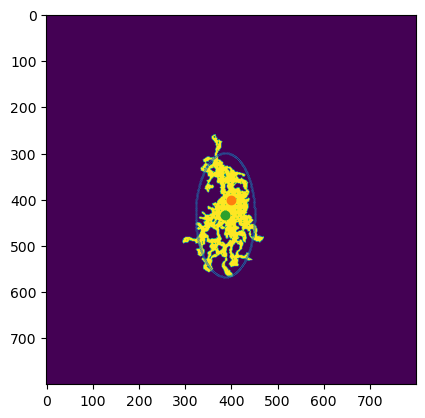

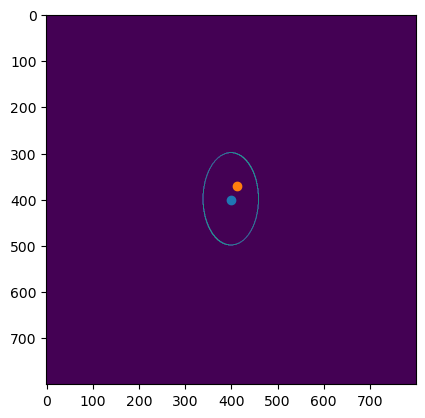

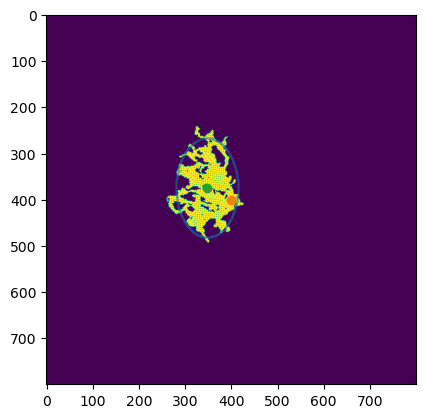

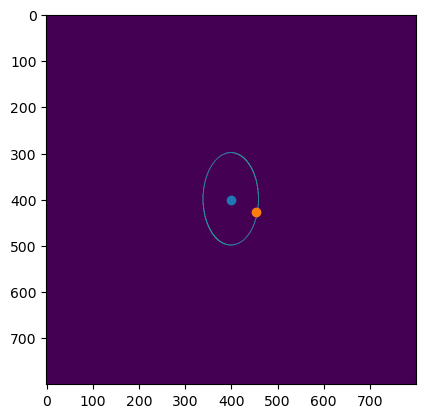

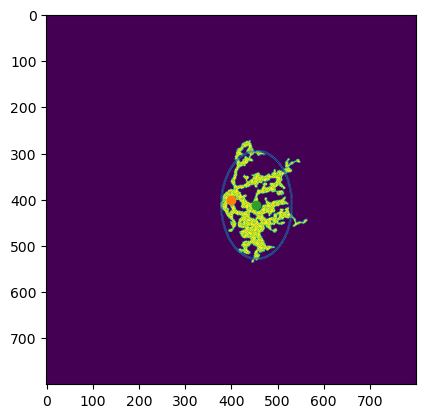

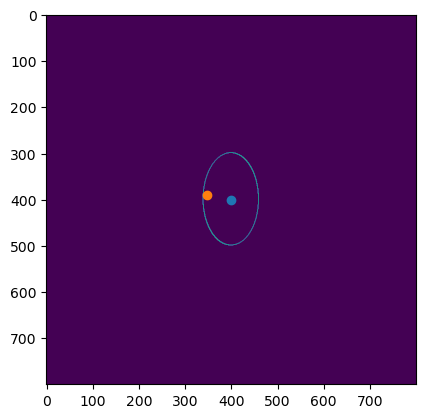

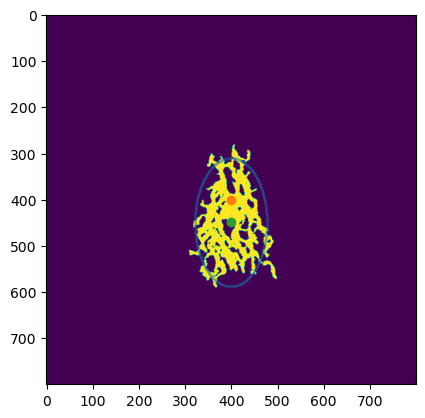

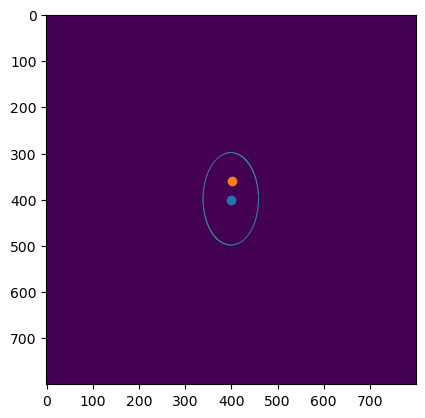

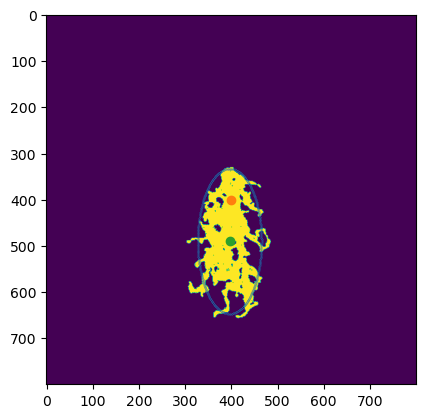

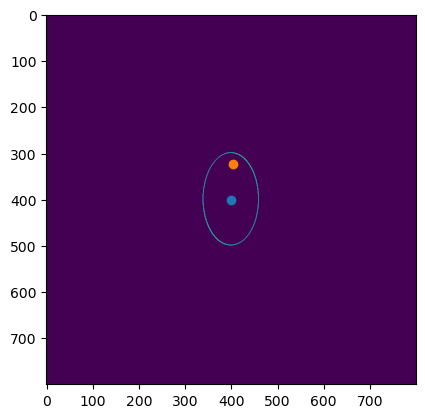

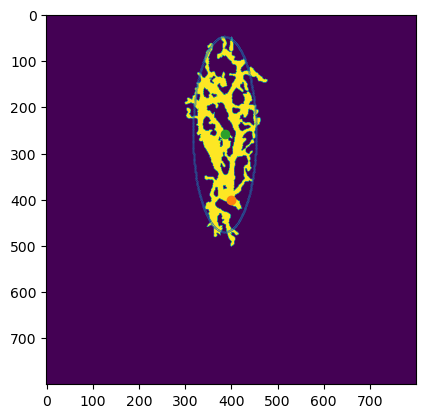

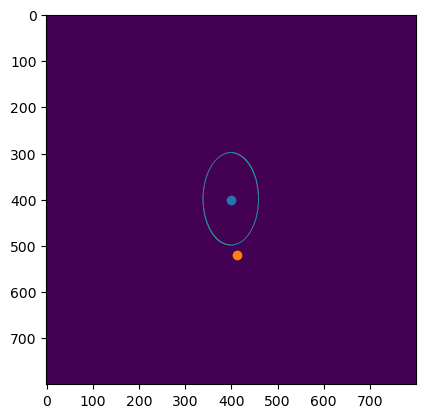

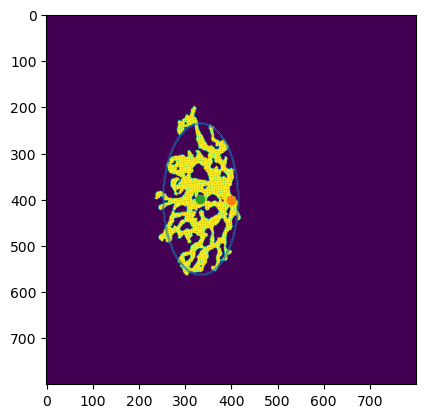

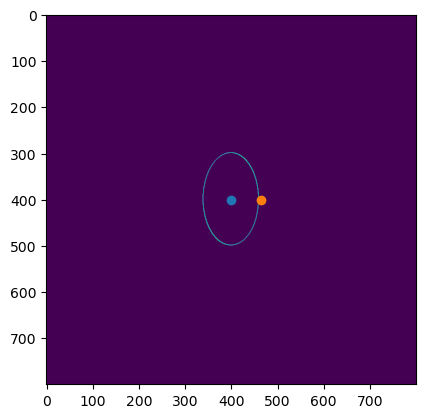

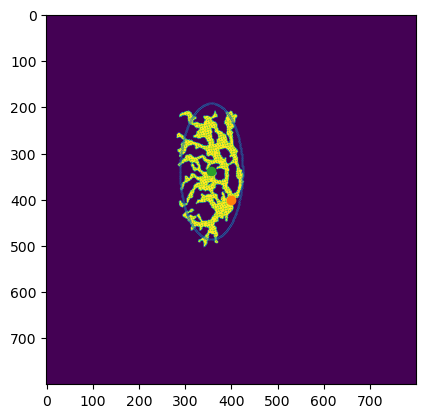

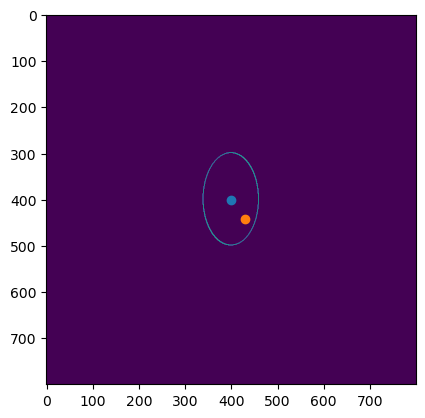

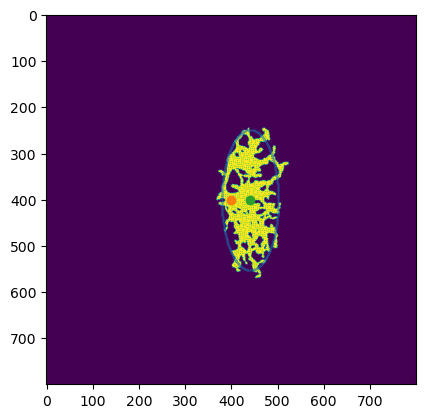

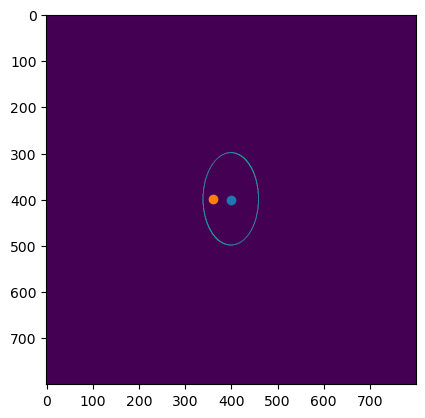

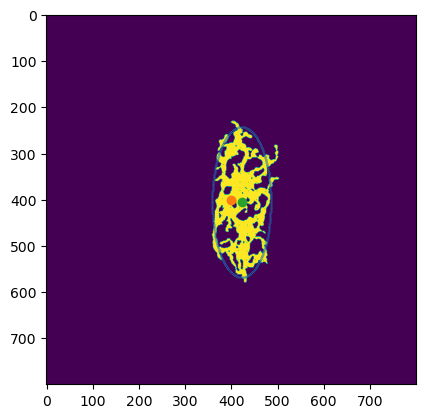

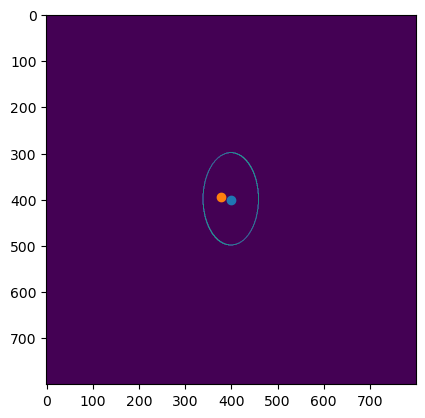

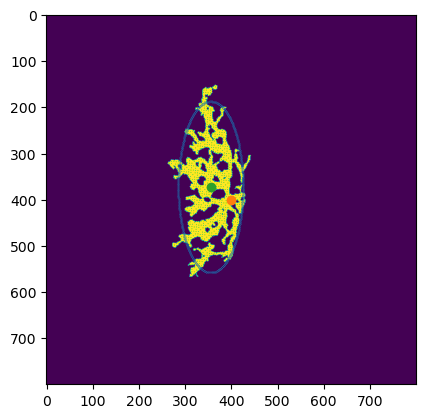

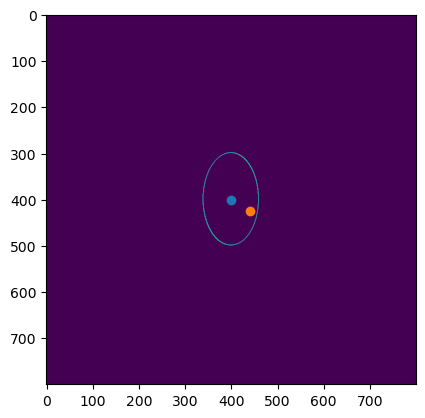

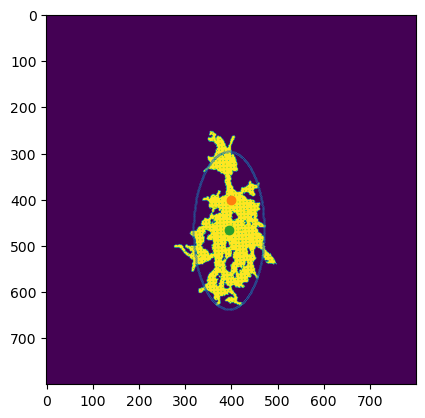

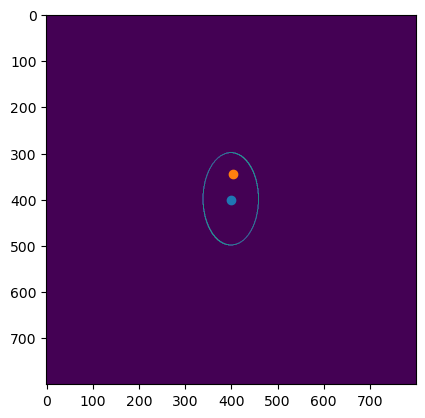

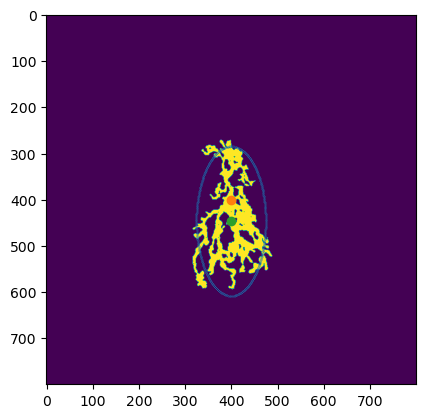

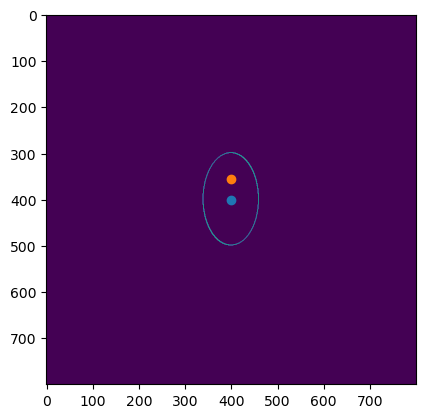

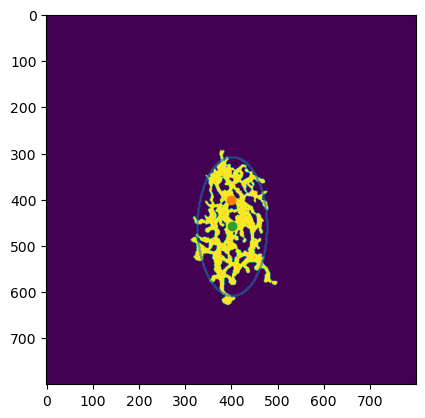

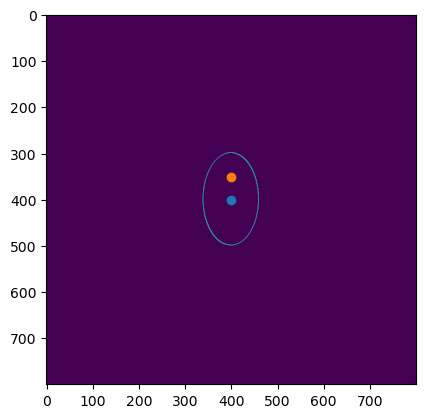

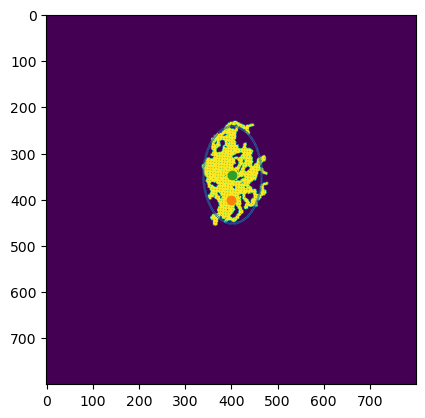

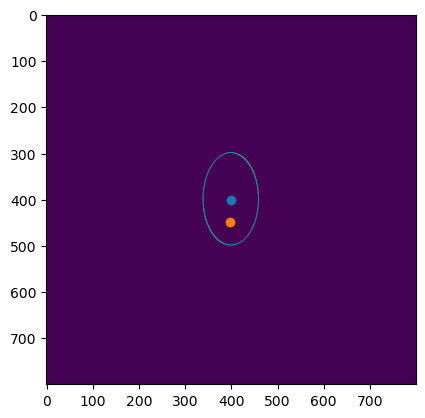

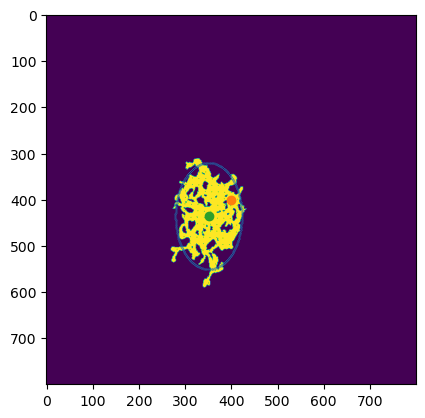

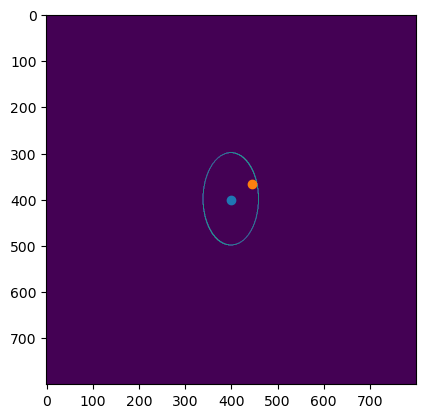

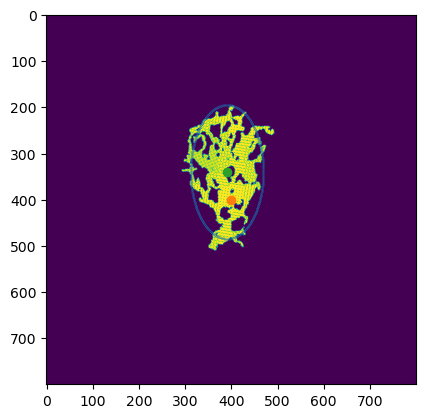

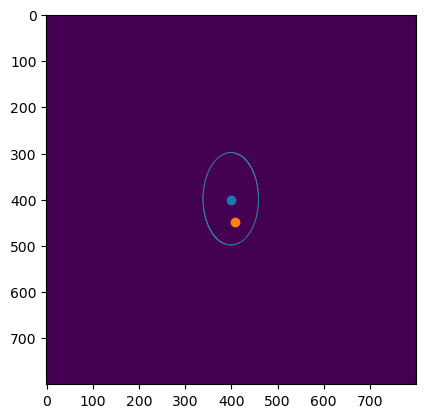

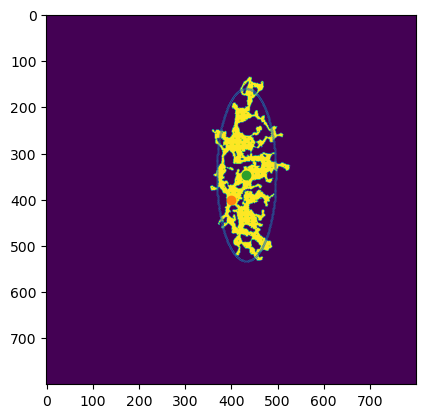

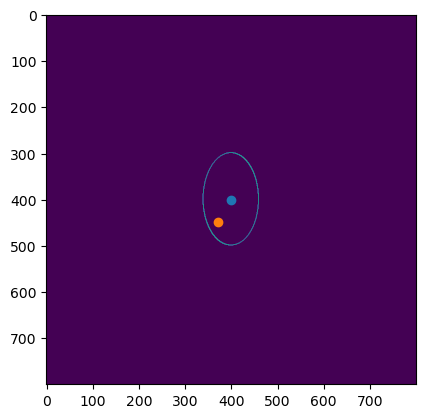

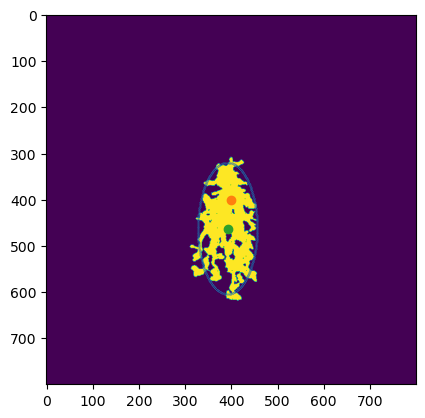

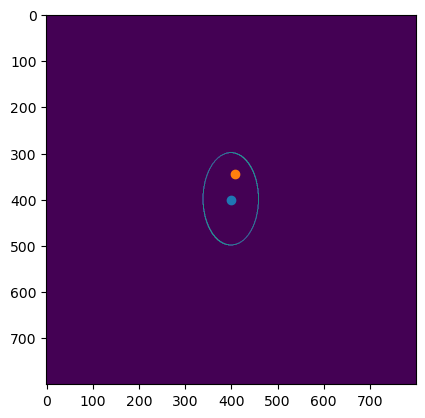

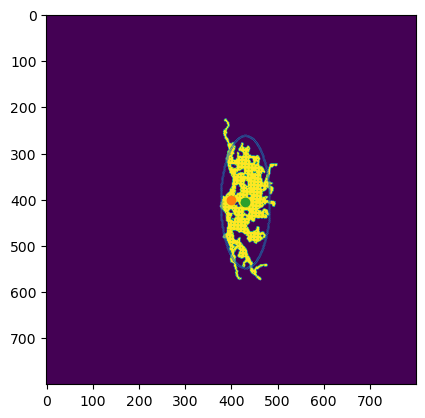

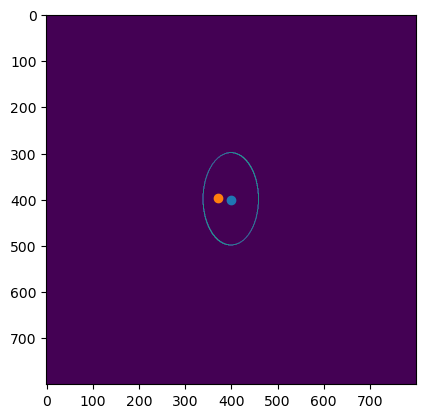

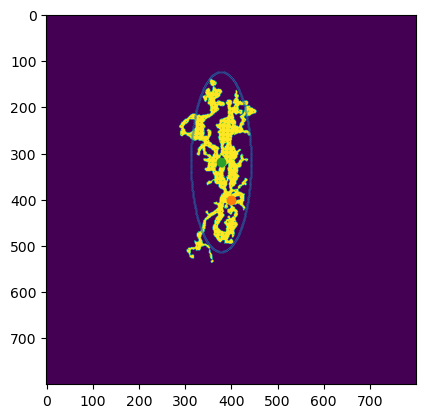

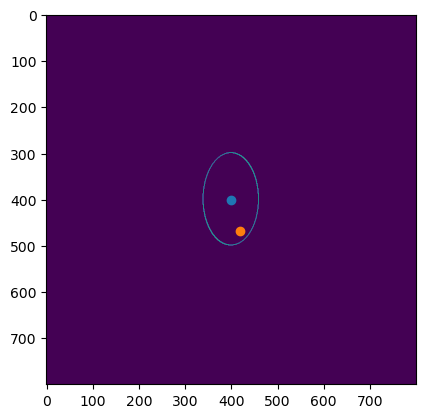

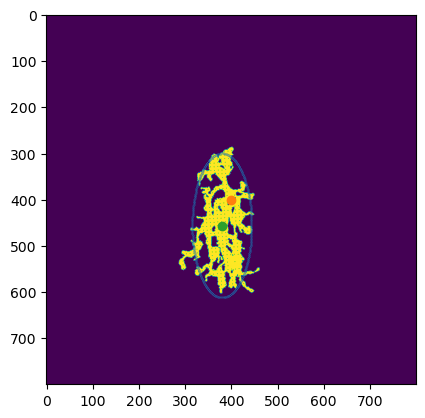

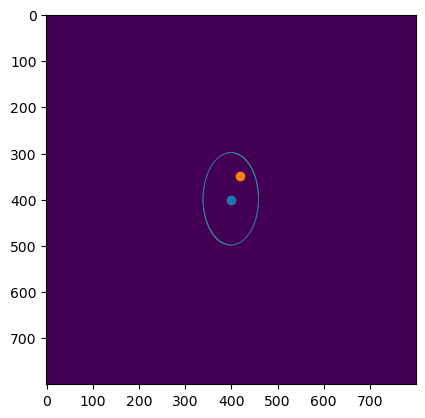

In [9]:
Y,X = 800, 800
results_cols = ['neuron','subtype','ratio']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    # plt.imshow(img_2d)
    # plt.scatter(entry_point[2], entry_point[1])
    # plt.show()

    asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2d,entry_point[1:],plot=False)

    img_transformed = np.zeros((Y,X))
    test = shifted_coor.copy()
    test[:,0]  = test[:,0]+X/2
    test[:,1] = -1*test[:,1]+Y/2
    for i in test:
        x,y = int(i[0]), int(i[1])
        img_transformed[y,x] = 1
    img_transformed = img_transformed.astype('uint8')
    new_region = regionprops(img_transformed)[0]
    new_center = new_region.centroid
    major_1, minor_1 = new_region.axis_major_length, new_region.axis_minor_length

    # Drawing ellipse1
    x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
    y0 = new_center[0]; b = major_1/2  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.imshow(img_transformed)
    plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
    plt.scatter(Y/2,X/2)
    plt.scatter(new_center[1],new_center[0])
    plt.show()

    y_f,x_f, ratio = analysis.transform_point2(theta=0,y=Y/2, x=X/2, 
                                                x0=new_center[1], y0=new_center[0], #center of ellipse1 
                                                a0=major_1, b0=minor_1, #major and minor of ellispe1
                                                x1=X/2, y1=Y/2, #center of ellipse2 (ref)
                                                a1=100, b1=60) # major and minor of ellipse2)
    

        # Drawing ellipse1
    x0 = X/2; a = 60  # x center, half width                                       
    y0 = Y/2; b = 100  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    ellipse = np.zeros((Y,X))
    for i in contour1:
        y,x = int(i[0]), int(i[1])
        ellipse[y,x] = 1
    plt.imshow(ellipse)
    plt.scatter(X/2,Y/2)
    plt.scatter(x_f,y_f)
    plt.show()

    results_df.loc[neuron_n] = [neuron_n, subtype, ratio]

In [5]:
Y,X = 800, 800
results_cols = ['neuron','subtype','ratio']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    
    ori_region = regionprops(img_2d)[0]


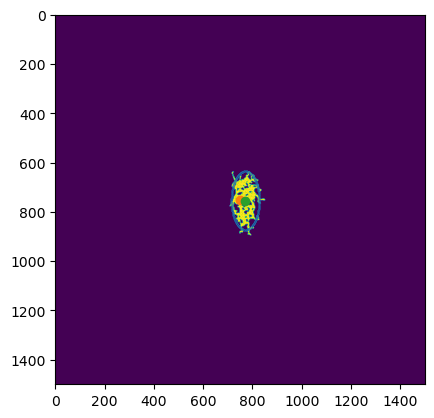

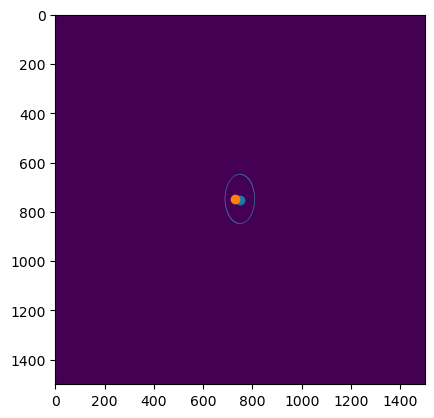

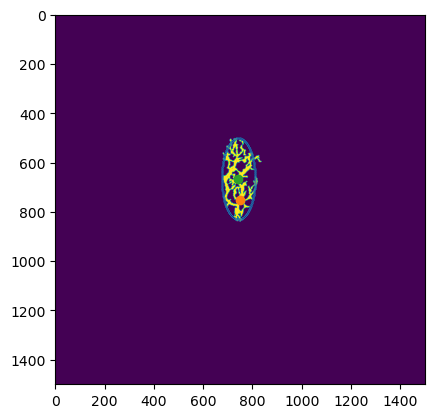

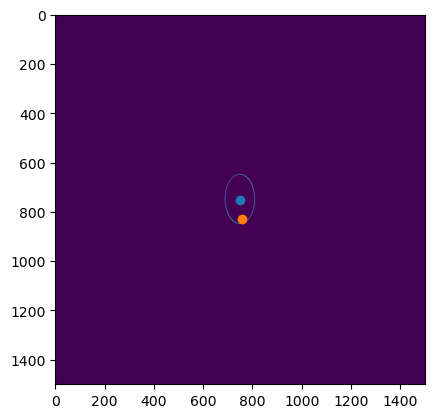

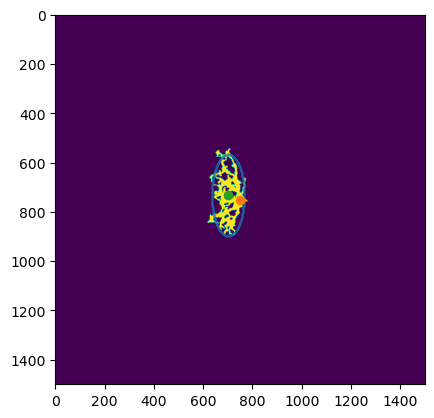

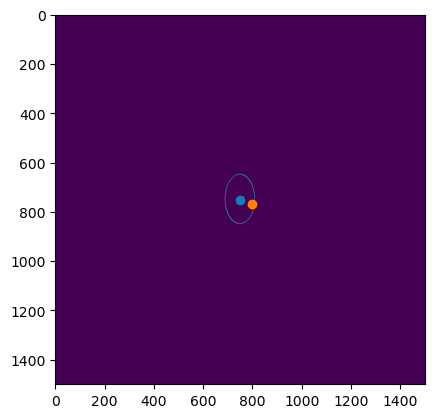

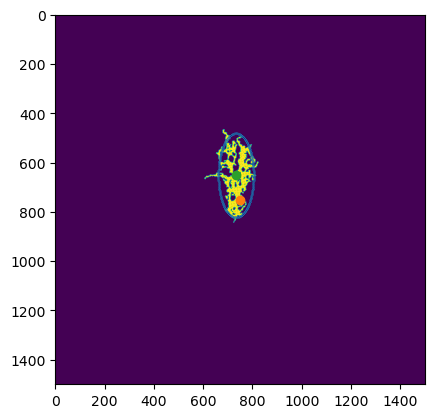

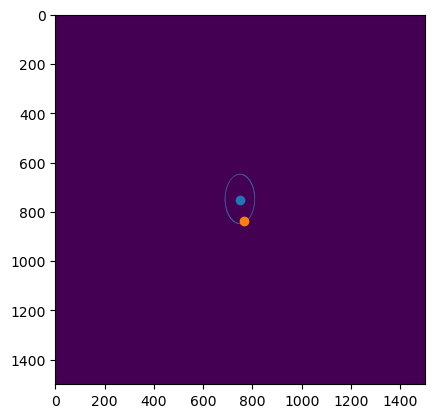

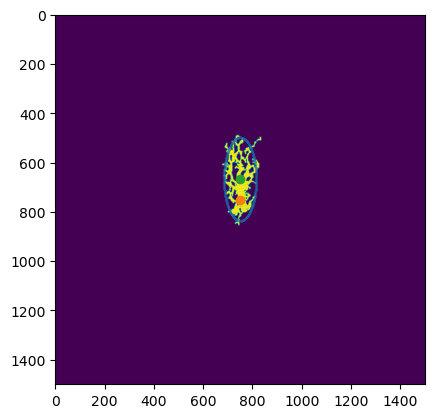

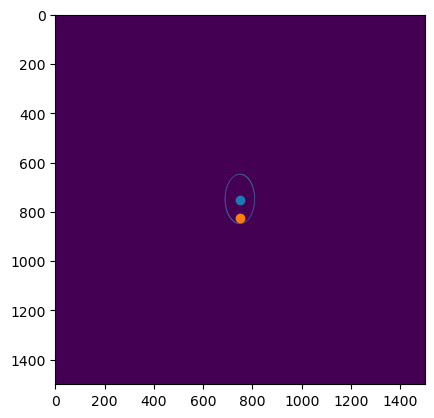

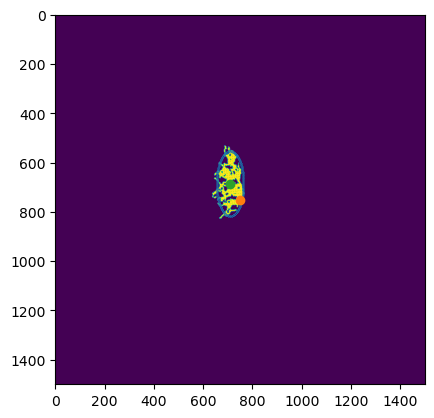

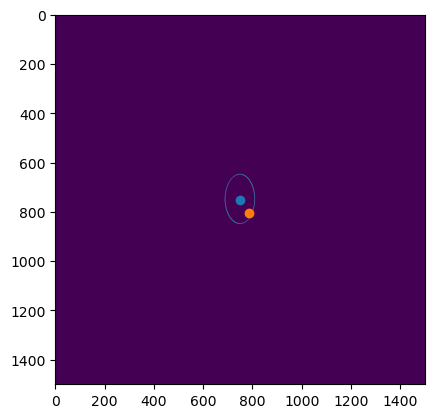

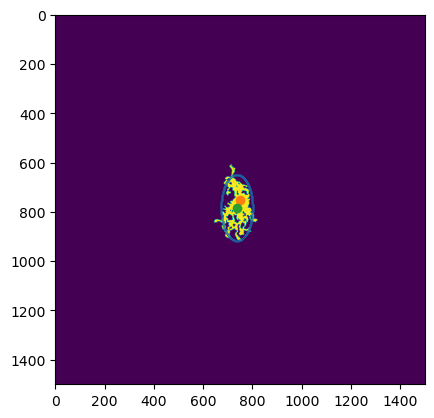

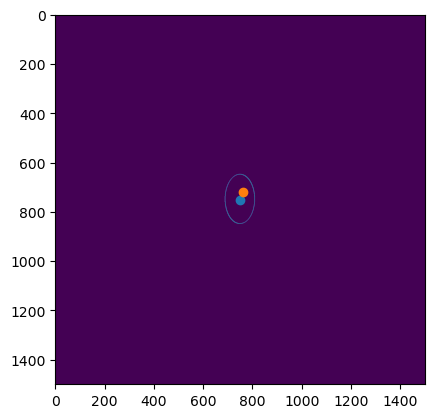

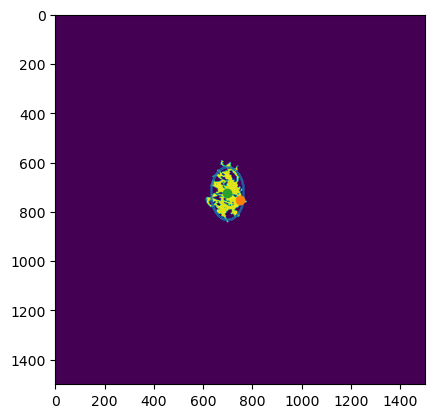

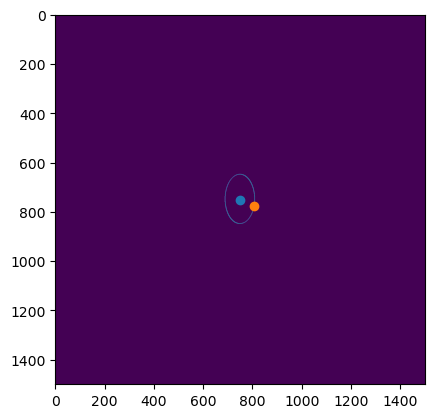

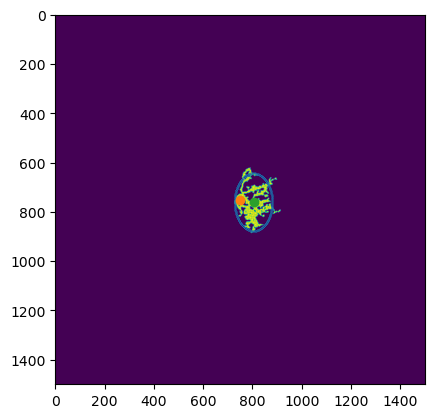

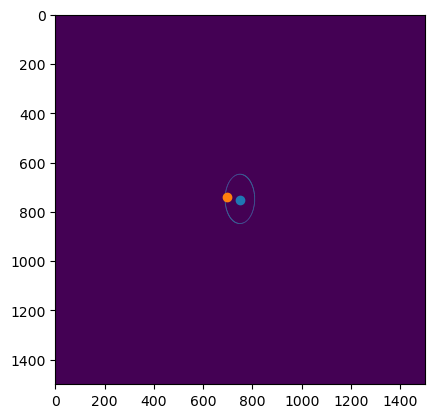

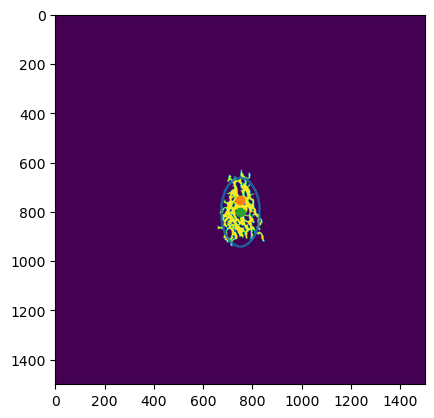

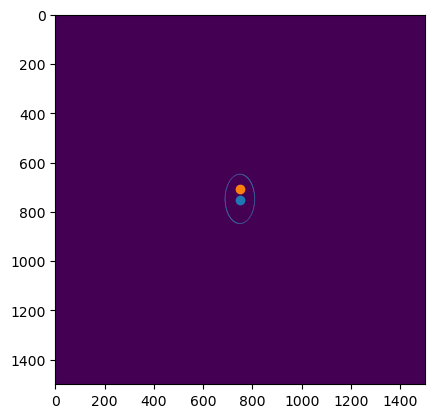

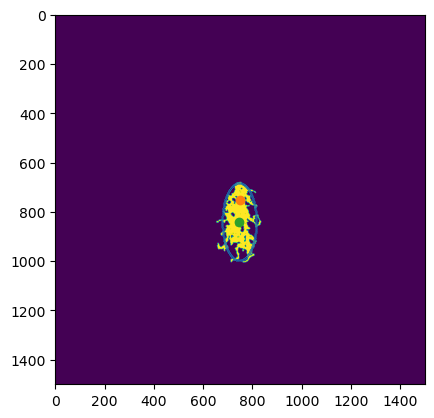

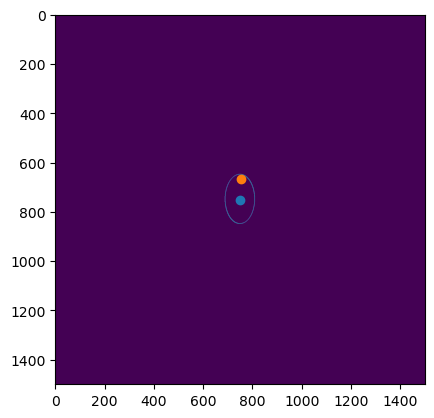

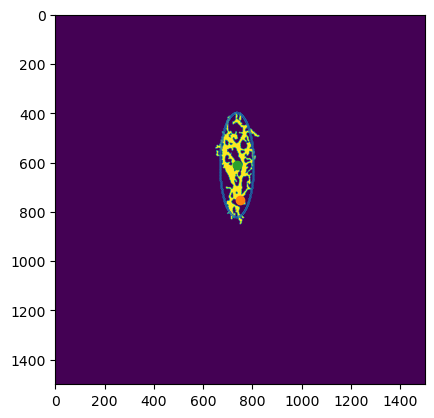

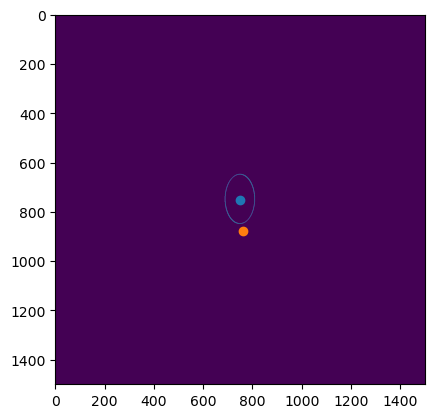

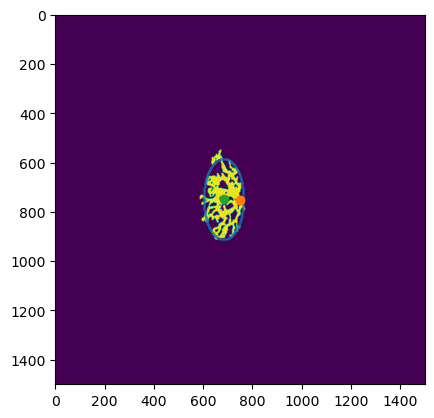

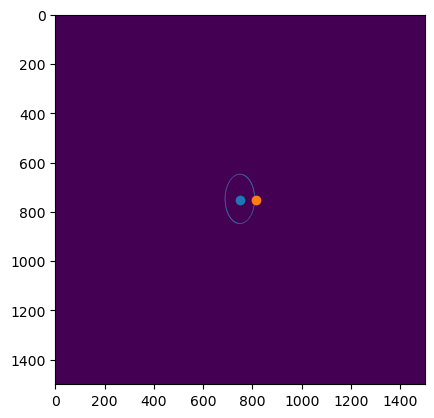

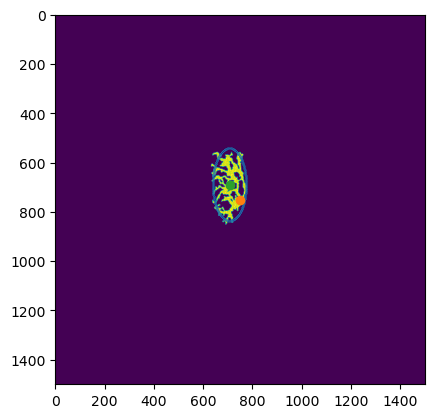

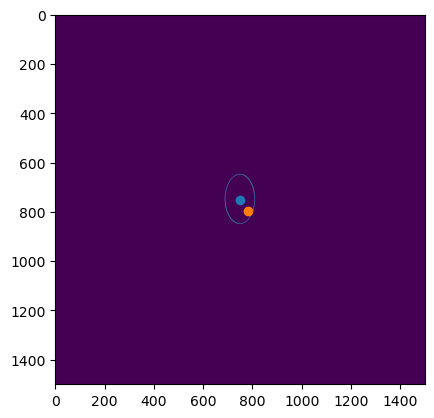

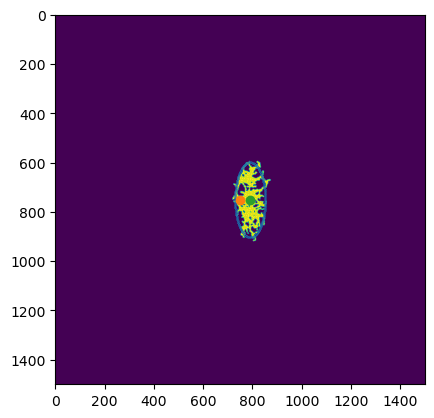

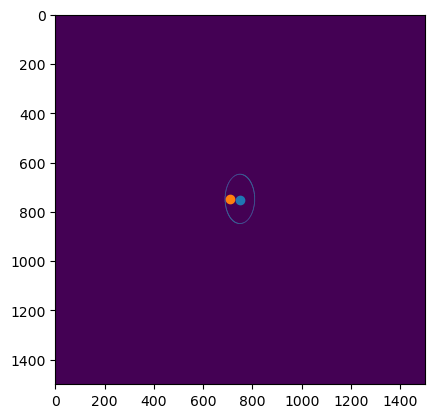

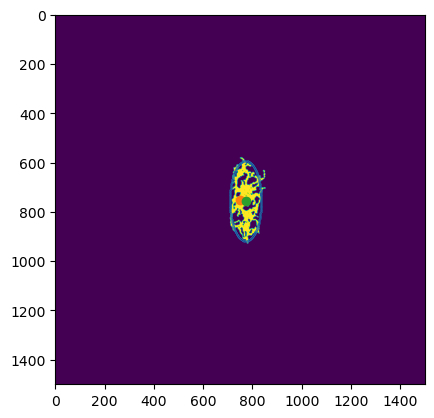

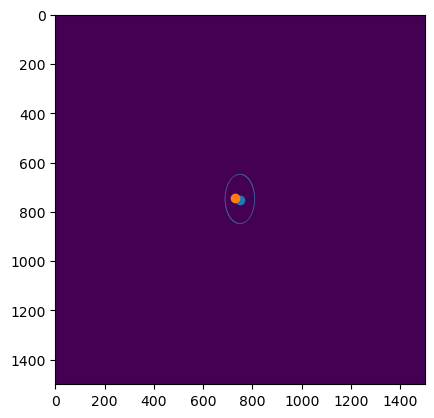

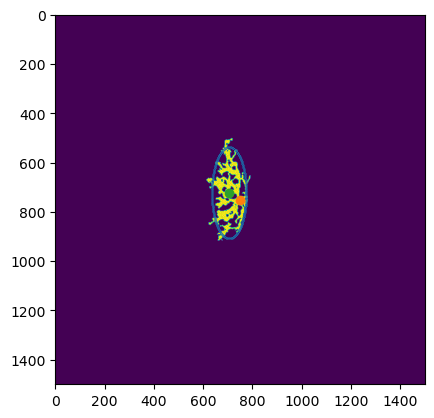

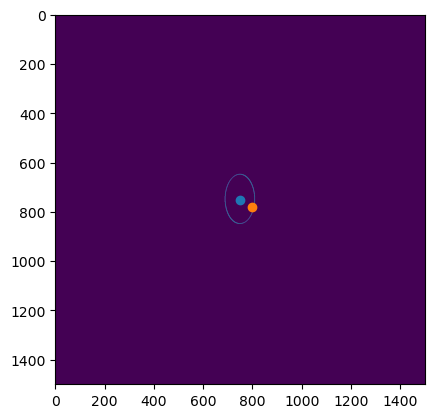

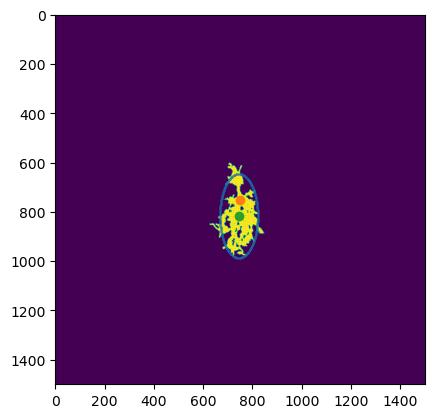

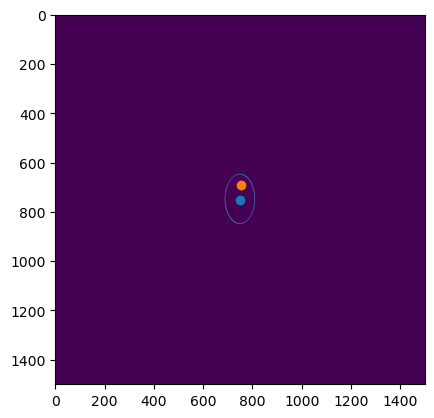

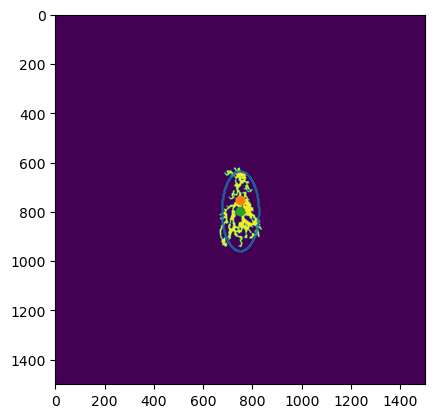

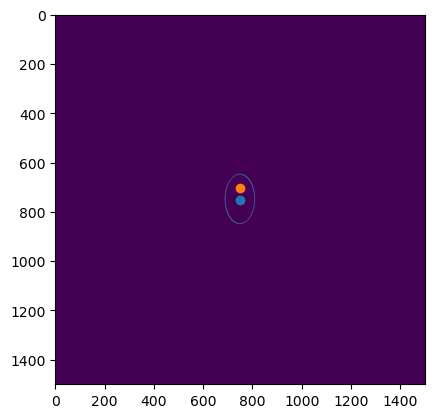

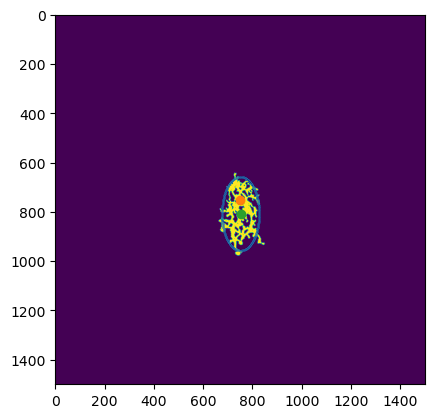

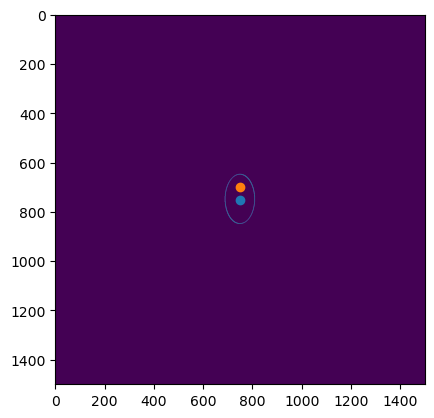

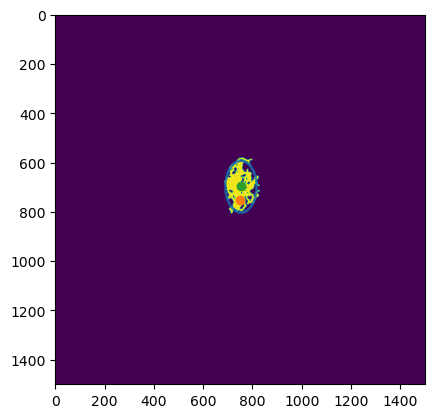

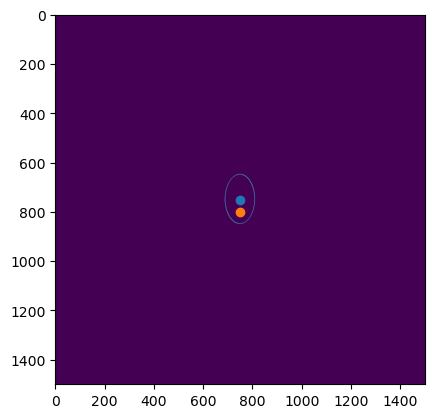

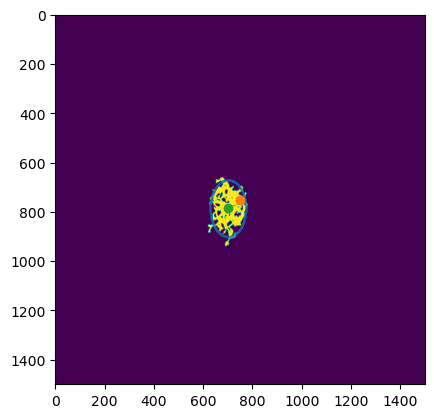

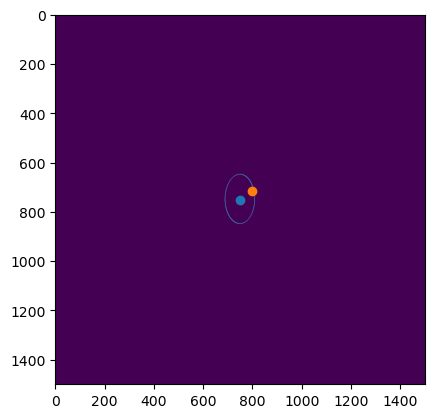

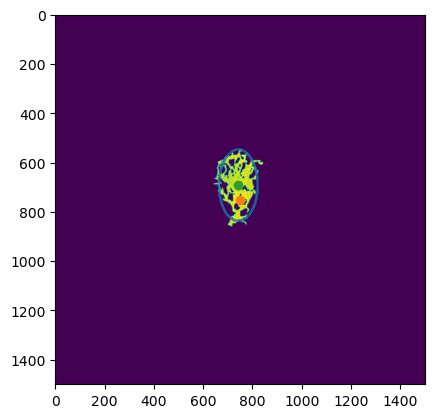

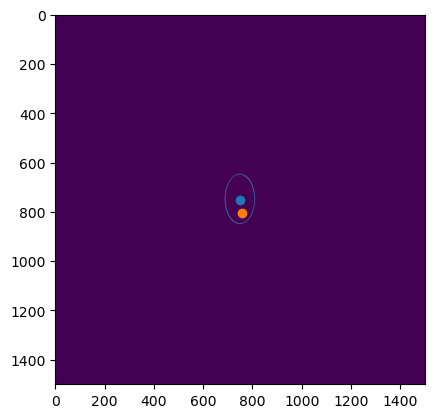

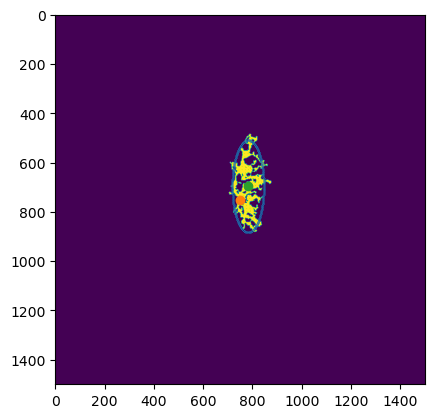

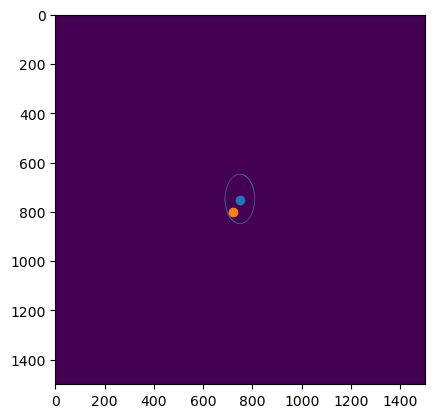

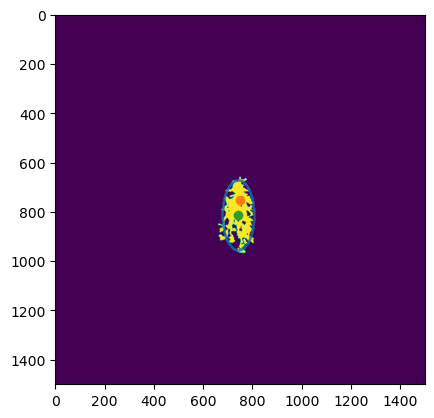

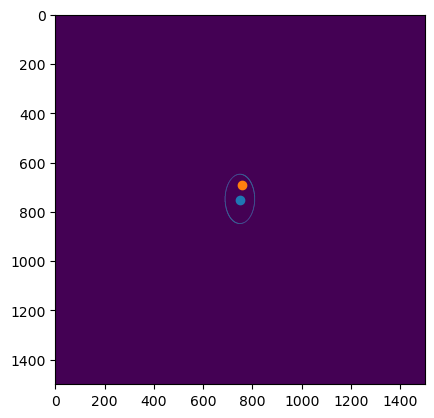

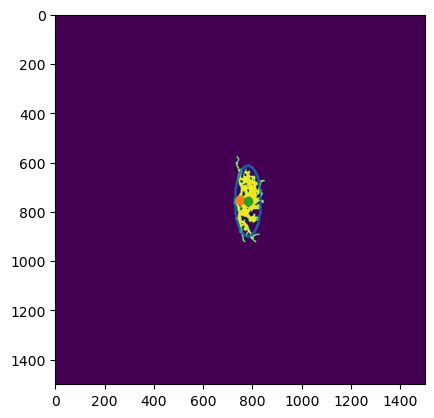

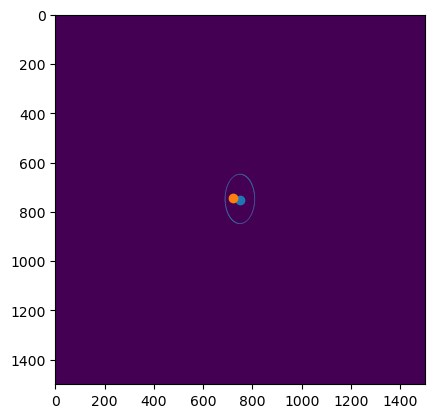

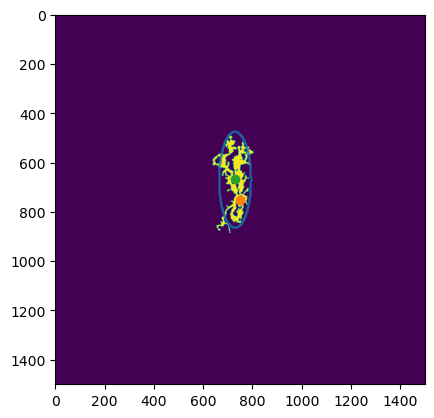

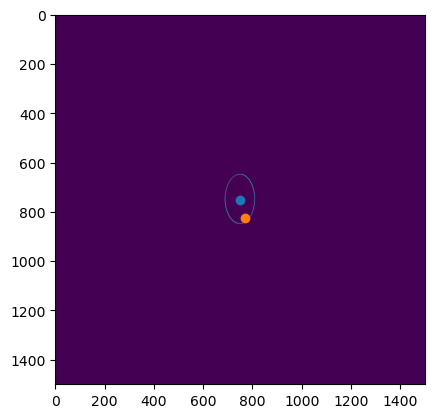

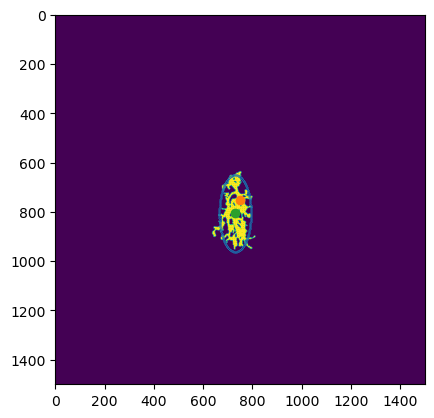

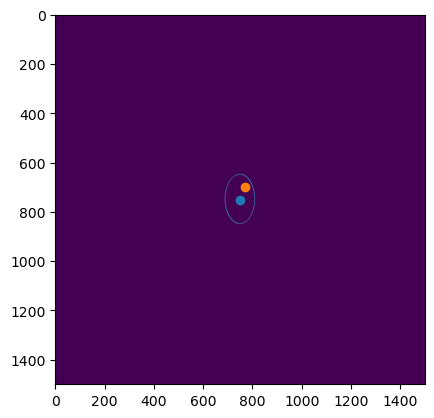

In [6]:
Y,X = 1500, 1500
results_cols = ['neuron','subtype','ratio']
results_df = pd.DataFrame(columns=results_cols)
for neu_file in N_folders:
    # getting entry point
    # neu_res['neuron'] = neu_file[:-6]
    neuron_n = neu_file[:-6]
    subtype = neu_file[-5]
    entry_point = np.array(entry_points[neu_file[:-6]])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    img_2d = image.max(axis=0)
    # plt.imshow(img_2d)
    # plt.scatter(entry_point[2], entry_point[1])
    # plt.show()

    asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2d,entry_point[1:],plot=False)
    img_transformed = np.zeros((Y,X))
    test = shifted_coor.copy()
    test[:,0]  = test[:,0]+X/2
    test[:,1] = -1*test[:,1]+Y/2
    for i in test:
        x,y = int(i[0]), int(i[1])
        img_transformed[y,x] = 1
    img_transformed = img_transformed.astype('uint8')
    new_region = regionprops(img_transformed)[0]
    new_center = new_region.centroid
    major_1, minor_1 = new_region.axis_major_length, new_region.axis_minor_length

    # Drawing ellipse1
    x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
    y0 = new_center[0]; b = major_1/2  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    plt.imshow(img_transformed)
    plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
    plt.scatter(Y/2,X/2)
    plt.scatter(new_center[1],new_center[0])
    plt.show()

    y_f,x_f, ratio = analysis.transform_point2(y=Y/2, x=X/2, 
                                x0=new_center[1], y0=new_center[0], #center of ellipse1 
                                a0=major_1, b0=minor_1, #major and minor of ellispe1
                                x1=X/2, y1=Y/2, #center of ellipse2 (ref)
                                a1=100, b1=60) # major and minor of ellipse2)
    

        # Drawing ellipse1
    x0 = X/2; a = 60  # x center, half width                                       
    y0 = Y/2; b = 100  # y center, half height 
    X1 = np.linspace(0, Y,X)  # x values of interest
    Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
    ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype(int)

    contour1 = find_contours(ellipse)[0]
    ellipse = np.zeros((Y,X))
    for i in contour1:
        y,x = int(i[0]), int(i[1])
        ellipse[y,x] = 1
    plt.imshow(ellipse)
    plt.scatter(X/2,Y/2)
    plt.scatter(x_f,y_f)
    plt.show()

(326.0, 309.5) 135.0 402.0 204.5 350.5


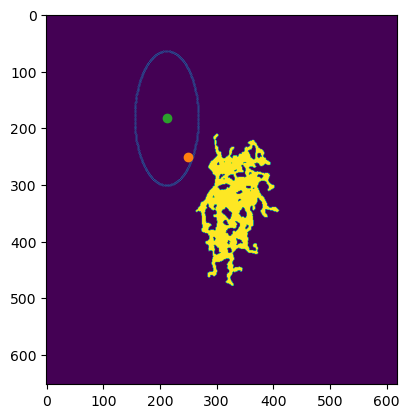

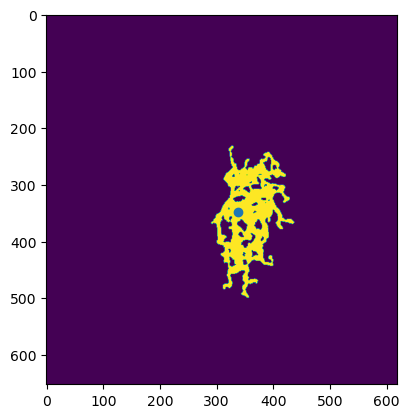

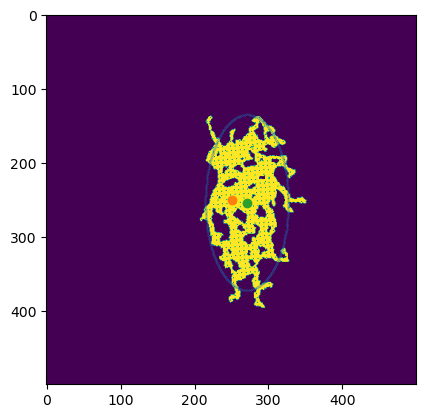

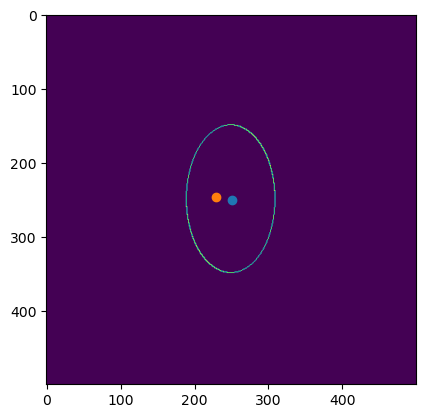

(405.5, 370.5) 5.5 341.5 169.5 328.5


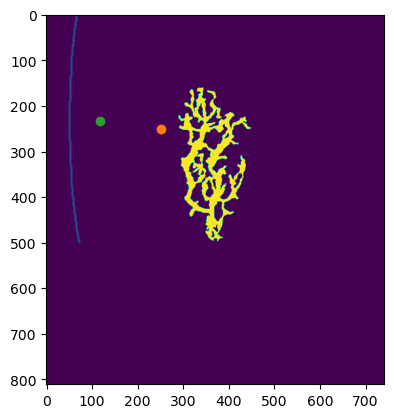

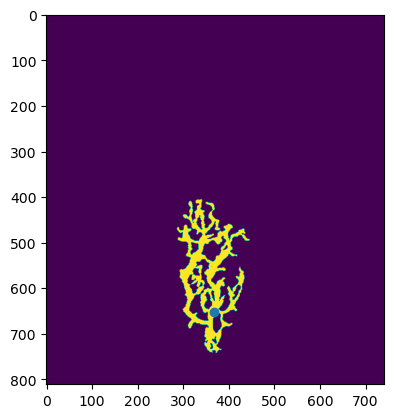

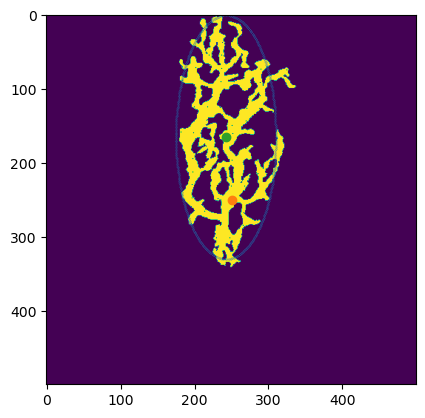

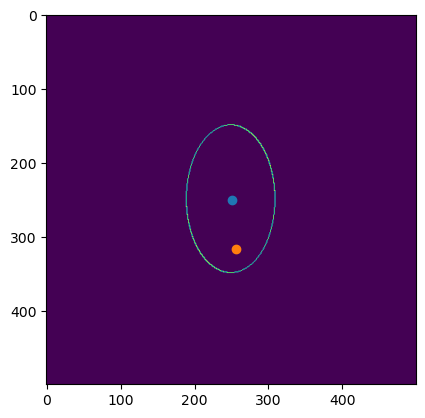

(512.0, 512.0) 43.0 395.0 115.0 282.0


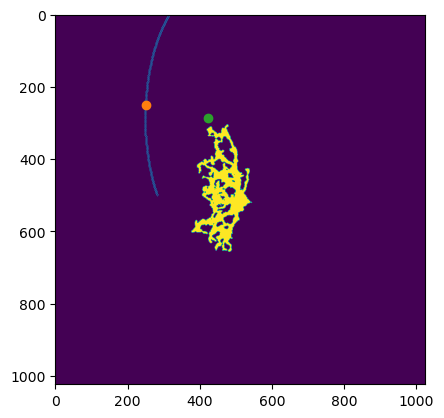

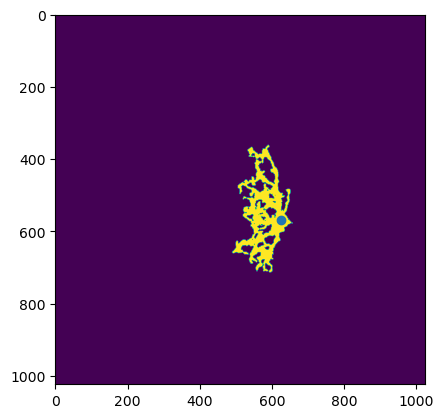

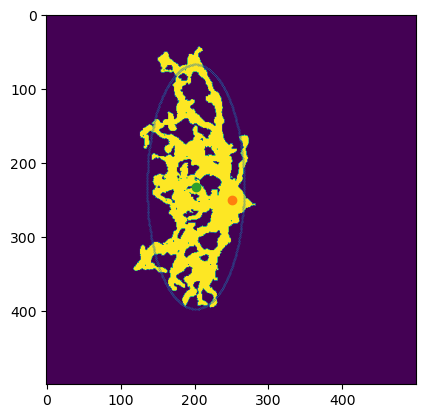

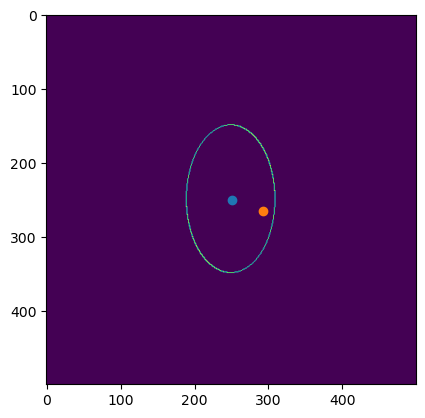

(512.0, 512.0) -19.0 348.0 95.0 302.0


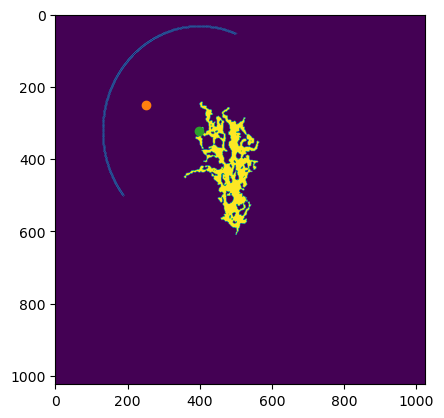

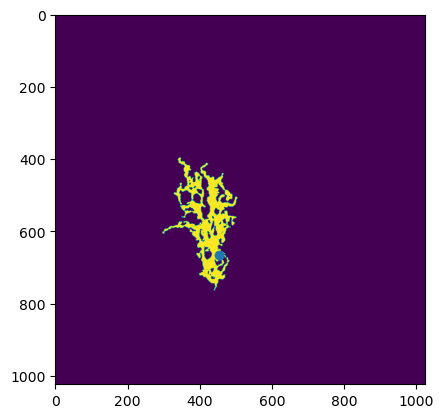

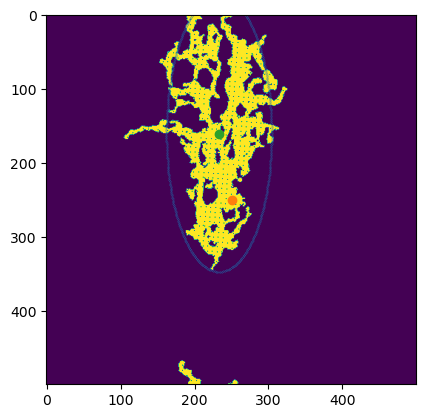

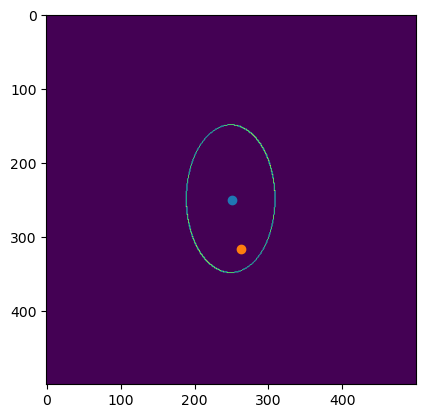

(512.0, 512.0) -12.0 355.0 154.0 309.0


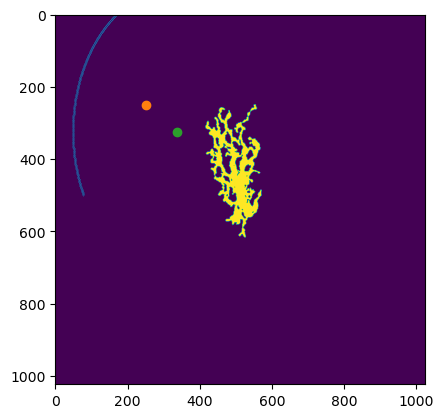

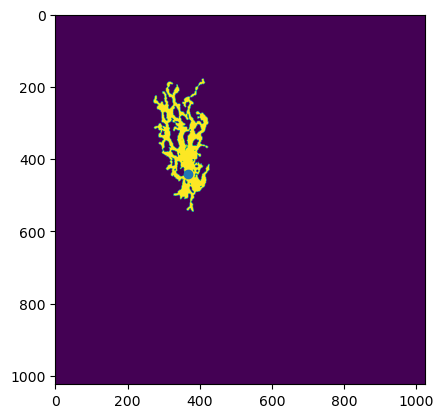

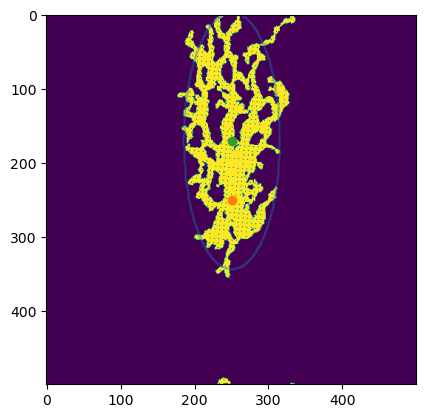

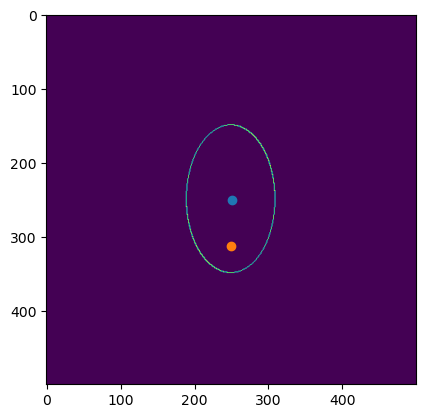

(512.0, 512.0) 45.0 340.0 133.0 265.0


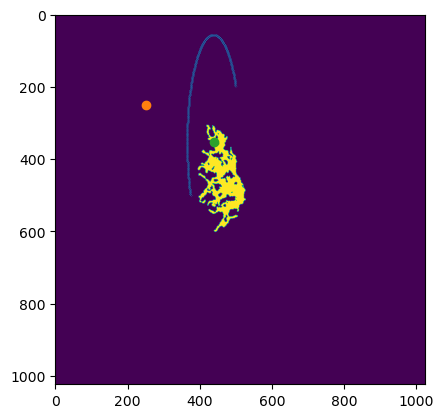

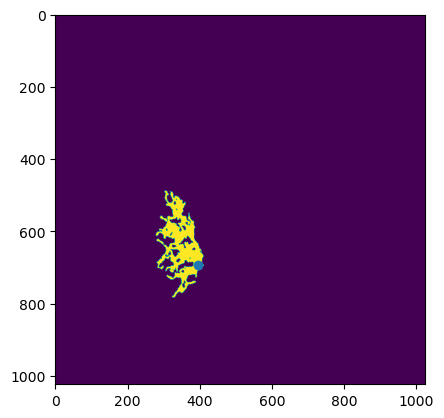

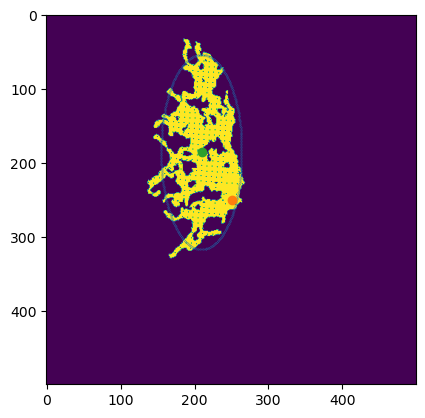

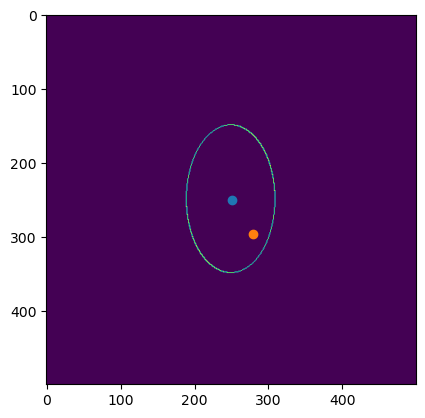

(512.0, 512.0) 108.0 417.0 138.0 313.0


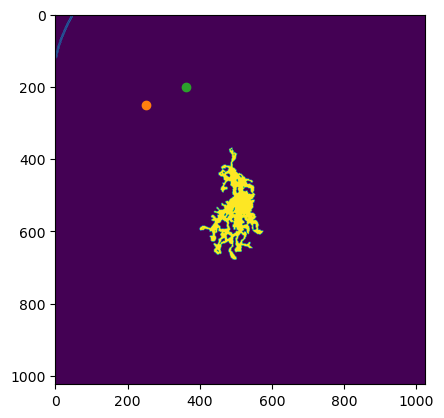

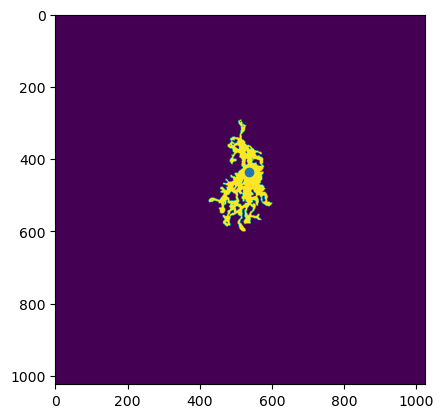

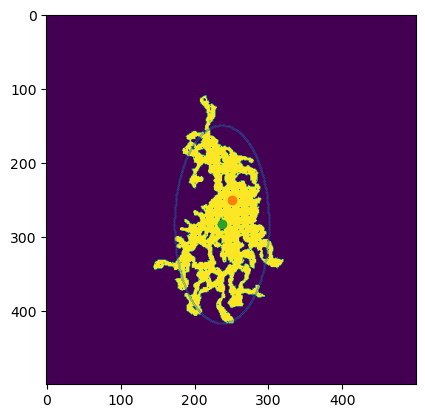

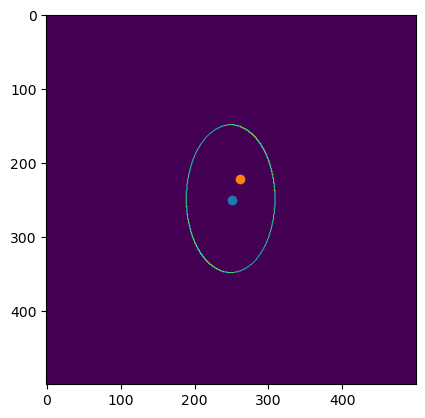

(512.0, 512.0) 113.0 352.0 114.0 279.0


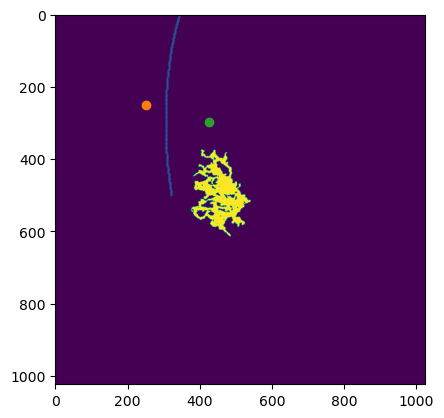

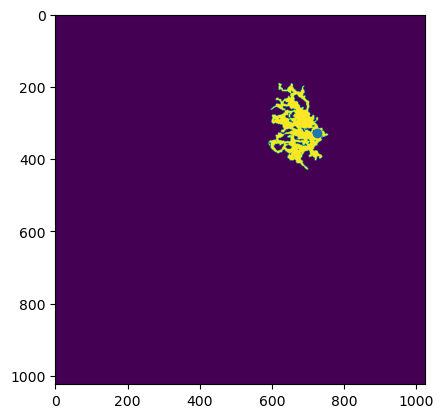

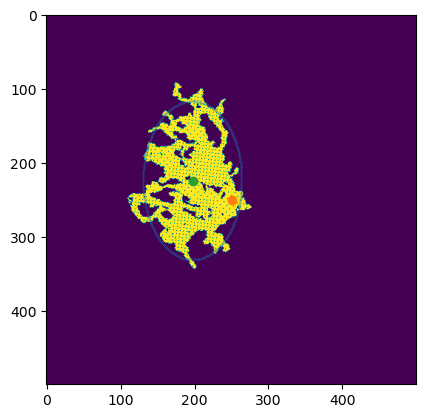

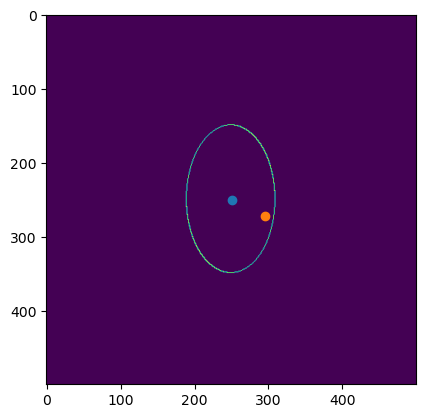

(512.0, 512.0) 117.0 361.0 223.0 420.0


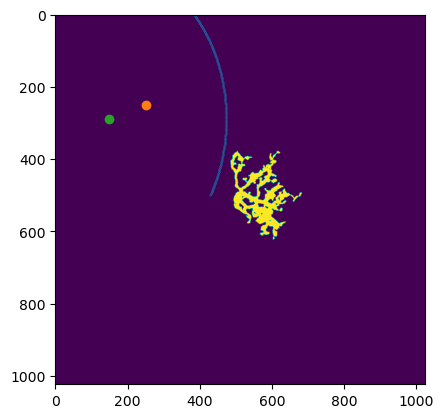

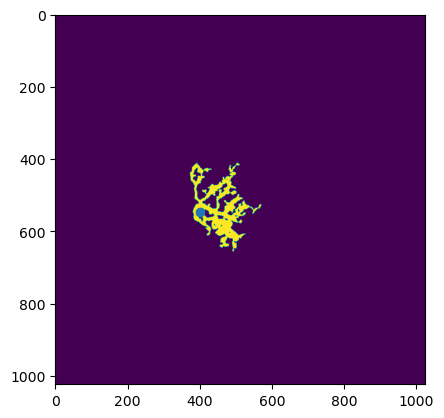

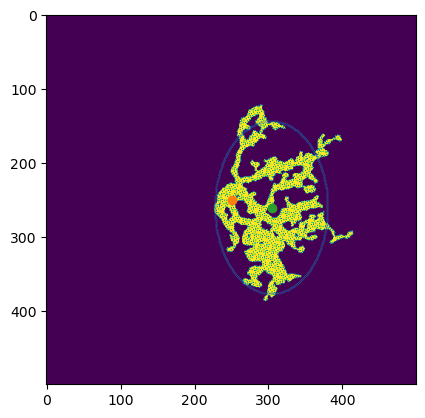

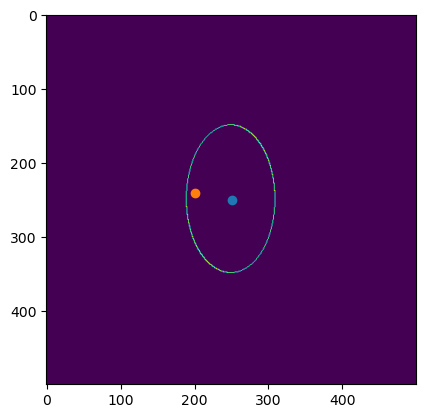

(351.0, 474.0) 133.0 440.0 156.0 344.0


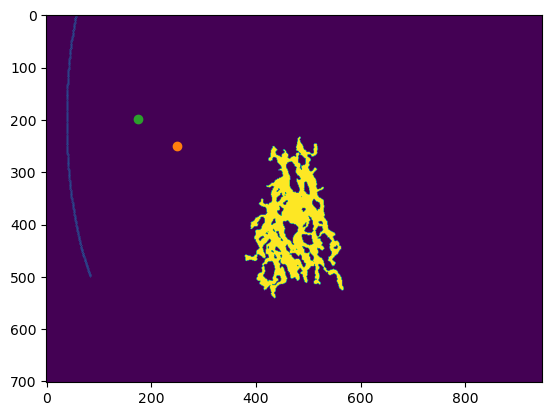

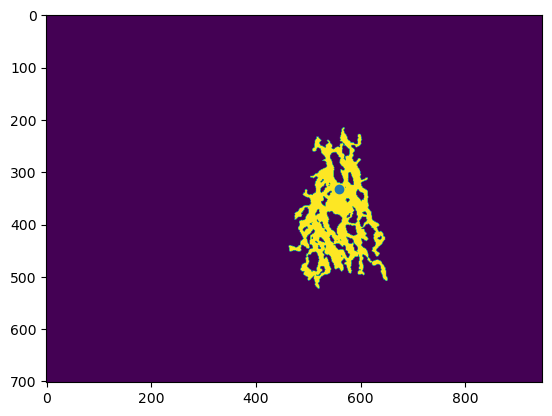

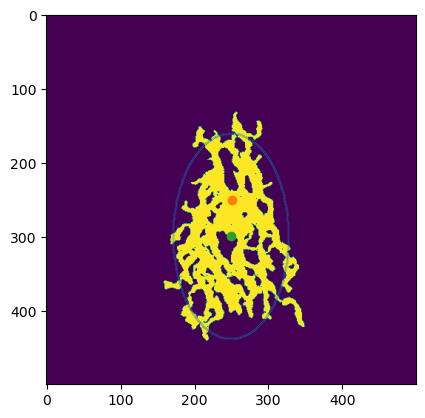

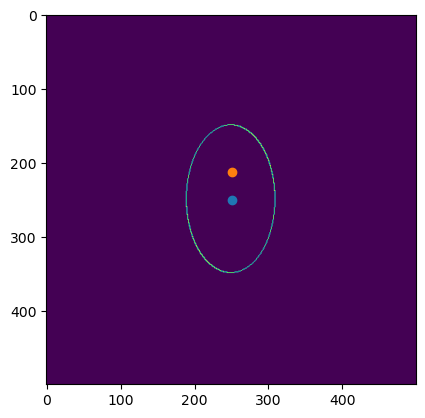

(353.0, 326.5) 182.0 508.0 148.5 331.5


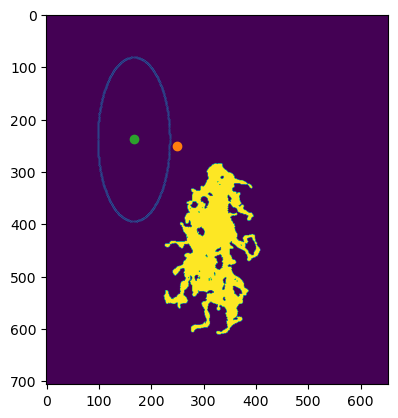

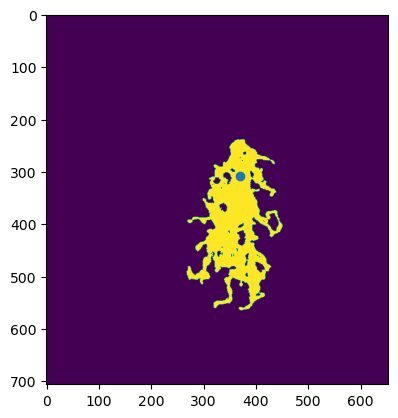

IndexError: index 500 is out of bounds for axis 0 with size 500

In [26]:
plt.imshow

In [14]:
results_df.groupby('subtype').agg({'ratio':'mean'})

ratio
subtype          
A        0.080376
B        0.213969
C        0.010812
D        0.025813

In [10]:
results_df.groupby('subtype').agg({'ratio':'mean'})

ratio
subtype          
A        0.080376
B        0.213969
C        0.010812
D        0.025813

In [31]:
neu_file = N_folders[12]
neu_res = {}
# getting entry point
try:
    neu_res['subtype'] = neu_file[-5]
except:
    neu_res['subtype'] = 'N'
# neu_res['neuron'] = neu_file.rstrip('.tif')
neu_res['neuron'] = neu_file[:-6]
entry_point = np.array(entry_points[neu_res['neuron']])
# reading image and make sure it's binary
image = tif.imread(data_path+neu_file)
image[image!=0] = 1
neu_res['entry_point'] = entry_point

In [32]:
image.shape

(22, 1024, 1024)

In [33]:
img_2d = image.max(axis=0)

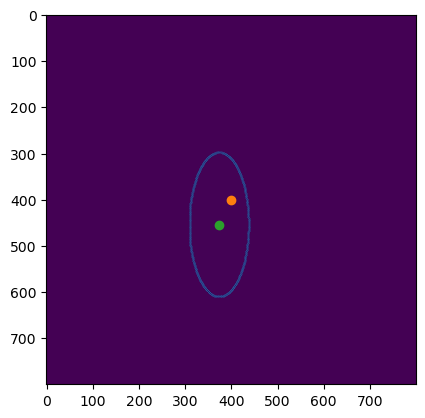

In [8]:
x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
y0 = new_center[0]; b = major_1/2  # y center, half height 
X1 = np.linspace(0, Y,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
img_transformed = np.empty_like(img_transformed)
plt.imshow(img_transformed)
plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
plt.scatter(Y/2,X/2)
plt.scatter(new_center[1],new_center[0])
plt.show()

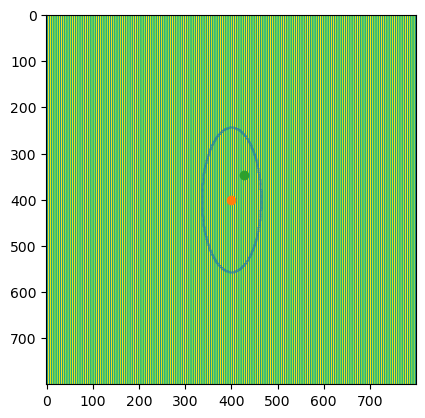

In [26]:
EP1 = (Y/2-(new_center[0]-Y/2), X/2-(new_center[1]-X/2))

x0 = new_center[1]-(new_center[1]-X/2); a = minor_1/2  # x center, half width                                       
y0 = new_center[0]-(new_center[0]-Y/2); b = major_1/2  # y center, half height 
X1 = np.linspace(0, Y,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
img_transformed = np.empty_like(img_transformed)
plt.imshow(img_transformed)
plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
plt.scatter(X/2,Y/2)
# plt.scatter(new_center[1],new_center[0])
plt.scatter(EP1[1],EP1[0])
# plt.legend()
plt.show()

In [17]:
X/2,Y/2

(400.0, 400.0)

In [18]:
new_center

(453.9374601774249, 373.6219183453414)

4.92773709969247 587.9222360315896 119.3087667092225


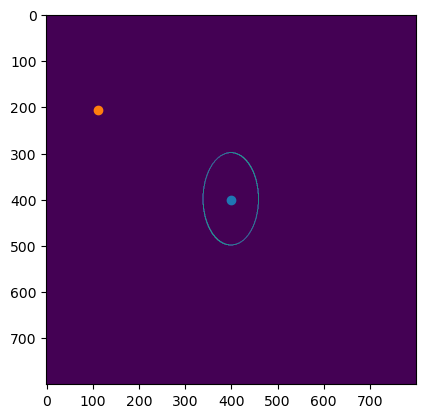

In [6]:


EP_new = (Y/2, X/2)
y_f,x_f, ratio = analysis.transform_point2(theta=theta,y=0, x=0, 
                                            x0=new_center[1], y0=new_center[0], #center of ellipse1 
                                            a0=major_1, b0=minor_1, #major and minor of ellispe1
                                            x1=new_center[1], y1=new_center[0], #center of ellipse2 (ref)
                                            a1=100, b1=60) # major and minor of ellipse2)


    # Drawing ellipse1
x0 = X/2; a = 60  # x center, half width                                       
y0 = Y/2; b = 100  # y center, half height 
X1 = np.linspace(0, Y,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((Y,X))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)
plt.scatter(X/2,Y/2)
plt.scatter(x_f,y_f)
plt.show()

In [8]:
y_f,x_f, ratio = analysis.transform_point2(theta=0,y=10, x=10, 
                                            x0=0, y0=0, #center of ellipse1 
                                            a0=major_1, b0=minor_1, #major and minor of ellispe1
                                            x1=0, y1=0, #center of ellipse2 (ref)
                                            a1=100, b1=60) # major and minor of ellipse2)

0.09404372671519211 14.142135623730951 150.37829866695816


In [64]:
def transform_point2(theta=0, y=200, x=80, 
                    x0=0, y0=0, #center of ellipse1 
                    a0=50, b0=100, #major and minor of ellispe1
                    x1=0, y1=0, #center of ellipse2 (ref)
                    a1=20, b1=40, # major and minor of ellipse2
                    X_length=150, #X_dim of final array
                    Y_length=250): #Y_dim of final array
    """
    This function transform the  y,x coordinates of a point in ellipse1 
    to y_f,x_f coordinate of the corresponding point in ellipse2
    INPUT: y,x coordinates of the point in ellipse1 
           y0,x0,a0,b0 center and dimaters of ellipse1 
           y1,x1,a1,b1 center and dimaters of ellipse2
    Returns y_f, x_f coordinates of the corresponding point in ellipse2
    NOTE: the point has to be inside the ellipse1 and not on the boarder
    """
    # find angle and distance of the point (y,x) from the center of ellipse1
    p1 = (y-y0,x-x0)
    p1_theta = np.arctan2(*p1)+theta
    p1_dist = np.linalg.norm(p1)
    
    # find the coordinates and distance of edge point on ellipse1 that has the same angle/p1_theta
    edge1_x = a0*b0/np.sqrt((a0**2+b0**2*np.tan(p1_theta)**2))+x0
    edge1_y = np.sqrt(1- (edge1_x/b0)**2)*a0+y0
    edge1_dist = np.linalg.norm((edge1_y-y0,edge1_x-x0))

    # find the coordinates and distance of edge point on ellipse2 that has the same angle/p1_theta
    edge2_x = a1*b1/np.sqrt((a1**2+b1**2*np.tan(p1_theta)**2))+x1
    edge2_y = np.sqrt(1- (edge2_x/b1)**2)*a1+y1
    # edge2_x = a1*b1/np.sqrt((a1**2+b1**2+np.tan(p1_theta)**2))+x1
    # edge2_y = edge2_x*np.tan(p1_theta)
    edge2_dist = np.linalg.norm((edge2_y-y1,edge2_x-x1))

    # find ratio of p1_dist to edge1_dist
    dist_ratio = p1_dist/edge1_dist
    print(dist_ratio, p1_dist, edge1_dist)

    # find corresponding distance of the point in ellipse2
    dist = edge2_dist * dist_ratio

    # find coordinates of the point in ellipse2
    x_f = dist*np.cos(p1_theta)+x1
    y_f = dist*np.sin(p1_theta)+y1

    return y_f, x_f, dist_ratio

In [65]:
theta=0
y_p=0
x_p=20
x0=0
y0=0 #center of ellipse1 
a0=150
b0=60
x1=0
y1=0 #center of ellipse2 (ref)
a1=200
b1=120

In [66]:
y_f,x_f, ratio = transform_point2(theta=0,y=y_p, x=x_p, 
                                            x0=0, y0=0, #center of ellipse1 
                                            a0=150, b0=60, #major and minor of ellispe1
                                            x1=0, y1=0, #center of ellipse2 (ref)
                                            a1=200, b1=120) # major and minor of ellipse2)

0.3333333333333333 20.0 60.0


In [67]:
p1 = (y_p-y0, x_p-x0)
p1_theta = np.arctan2(*p1)+theta
p1_dist = np.linalg.norm(p1)

In [68]:
# find the coordinates and distance of edge point on ellipse1 that has the same angle/p1_theta
edge1_x = a0*b0/np.sqrt((a0**2+b0**2*np.tan(p1_theta)**2))+x0
# edge1_y = edge1_x*np.tan(p1_theta)
edge1_y = np.sqrt(1- (edge1_x/b0)**2)*a0+y0
# edge1_y = y0-int(np.sqrt((np.tan(p1_theta)*(edge1_x-x0))**2))
edge1_dist = np.linalg.norm((edge1_y-y0,edge1_x-x0))

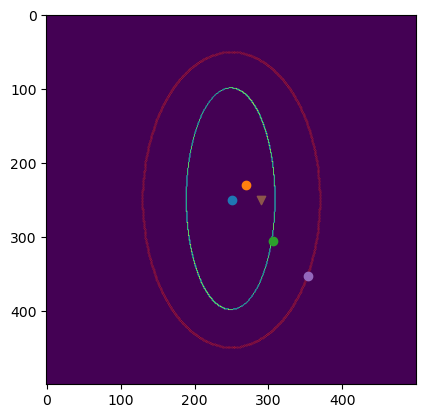

In [71]:
theta=0
y_p= -20
x_p=20
x0=0
y0=0 #center of ellipse1 
a0=150
b0=60
x1=0
y1=0 #center of ellipse2 (ref)
a1=200
b1=120

p1 = (y_p-y0, x_p-x0)
p1_theta = np.arctan2(*p1)+theta
p1_dist = np.linalg.norm(p1)

# find the coordinates and distance of edge point on ellipse1 that has the same angle/p1_theta
edge1_x = a0*b0/np.sqrt((a0**2+b0**2*np.tan(p1_theta)**2))+x0
# edge1_y = edge1_x*np.tan(p1_theta)
edge1_y = np.sqrt(1- (edge1_x/b0)**2)*a0+y0
# edge1_y = y0-int(np.sqrt((np.tan(p1_theta)*(edge1_x-x0))**2))
edge1_dist = np.linalg.norm((edge1_y-y0,edge1_x-x0))

# find the coordinates and distance of edge point on ellipse2 that has the same angle/p1_theta
edge2_x = a1*b1/np.sqrt((a1**2+b1**2*np.tan(p1_theta)**2))+x1
edge2_y = np.sqrt(1- (edge2_x/b1)**2)*a1+y1
edge2_dist = np.linalg.norm((edge2_y-y1,edge2_x-x1))

# Drawing ellipse1
X,Y = 500,500

x0=X/2
y0=Y/2 #center of ellipse1 
a = b0  # x center, half width                                       
b = a0 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((Y,X))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)
plt.scatter(X/2,Y/2)
plt.scatter(X/2+x_p,Y/2+y_p)
plt.scatter(X/2+edge1_x,Y/2+edge1_y)

x0=X/2
y0=Y/2 #center of ellipse1 
a = b1  # x center, half width                                       
b = a1 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
plt.scatter(X/2+edge2_x,Y/2+edge2_y)
plt.scatter(X/2+x_f,Y/2+y_f, marker='v')

plt.show()

In [531]:
a0, a1, b0, b1, edge1_x, edge1_y , edge2_x, edge2_y, edge1_dist

(150, 200, 60, 120, 60.0, 0.0, 120.0, 0.0, 60.0)

NameError: name 'x_f' is not defined

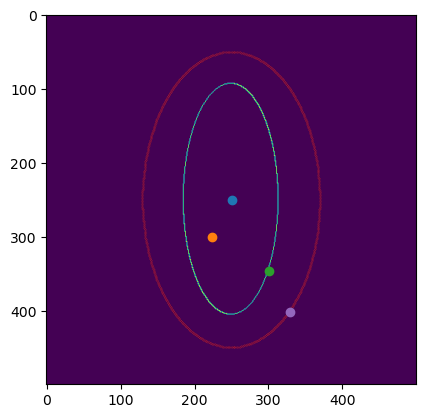

In [63]:
# Drawing ellipse1
X,Y = 500,500

x0=X/2
y0=Y/2 #center of ellipse1 
a = b0  # x center, half width                                       
b = a0 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((Y,X))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)
plt.scatter(X/2,Y/2)
plt.scatter(X/2+x_p,Y/2+y_p)
plt.scatter(X/2+edge1_x,Y/2+edge1_y)

x0=X/2
y0=Y/2 #center of ellipse1 
a = b1  # x center, half width                                       
b = a1 # y center, half height 
X1 = np.linspace(0, X,X)  # x values of interest
Y1 = np.linspace(0, Y,X)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X1-x0)/a)**2 + ((Y1-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
plt.scatter(contour1[:,1],contour1[:,0],s=0.01)
plt.scatter(X/2+edge2_x,Y/2+edge2_y)
plt.scatter(X/2+x_f,Y/2+y_f, marker='v')

plt.show()

In [50]:
X/2+x1,Y/2+y1

(250.0, 250.0)

In [39]:
# EP1 = (img_2d.shape[1]/2, img_2d.shape[0]/2)

In [40]:
# region_2D = regionprops(img_2d)[0]
# orientation1 = region_2D.orientation
# img_rotated = rotate(img_2d,-np.rad2deg(orientation1))
# img_rotated = img_rotated/img_rotated.max()
# img_rotated = img_rotated.astype('uint8')

In [41]:
# plt.imshow(img_rotated)
# plt.scatter(EP1[1],EP1[0])

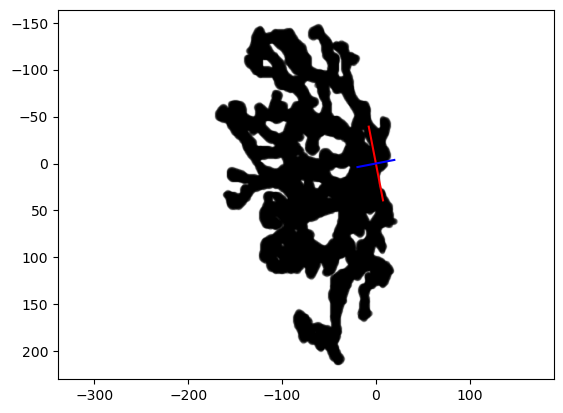

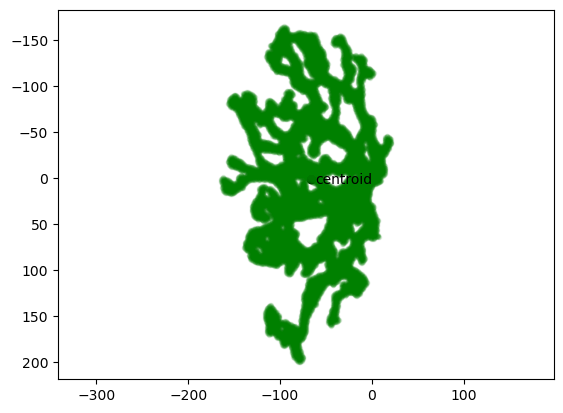

In [42]:
asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2d,entry_point[1:],plot=True)

In [43]:
shifted_coor.shape

(27400, 2)

In [44]:
img_transformed = np.zeros((500,500))
test = shifted_coor.copy()
test[:,0]  = test[:,0]+250
test[:,1] = -1*test[:,1]+250
for i in test:
    x,y = int(i[0]), int(i[1])
    img_transformed[y,x] = 1
img_transformed = img_transformed.astype('uint8')

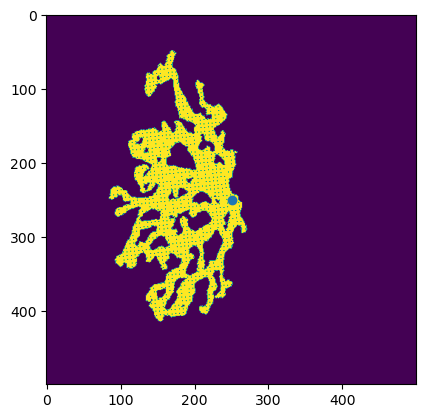

In [45]:
plt.imshow(img_transformed)
plt.scatter(250,250)

In [46]:
EP1 = (250,250)

In [47]:
new_region = regionprops(img_transformed)[0]
new_center = new_region.centroid

In [48]:
major_1, minor_1 = new_region.axis_major_length, new_region.axis_minor_length

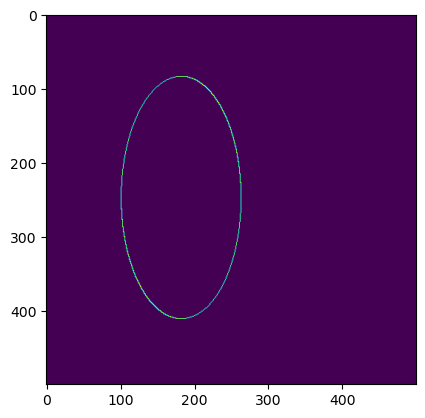

In [49]:
# Drawing ellipse1
x0 = new_center[1]; a = minor_1/2  # x center, half width                                       
y0 = new_center[0]; b = major_1/2  # y center, half height 
X = np.linspace(0, 500,500)  # x values of interest
Y = np.linspace(0, 500,500)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X-x0)/a)**2 + ((Y-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((500,500))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)

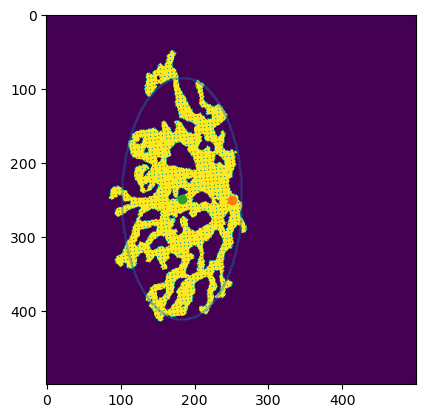

In [50]:
plt.imshow(img_transformed)
plt.scatter(contour1[:,1],contour1[:,0],marker='.',s=0.05)
plt.scatter(250,250)
plt.scatter(new_center[1],new_center[0])

In [51]:
y1,x1 = analysis.transform_point2(y=250, x=250, 
                                x0=new_center[1], y0=new_center[0], #center of ellipse1 
                                a0=minor_1, b0=major_1, #major and minor of ellispe1
                                x1=250, y1=250, #center of ellipse2 (ref)
                                a1=100, b1=60) # major and minor of ellipse2)

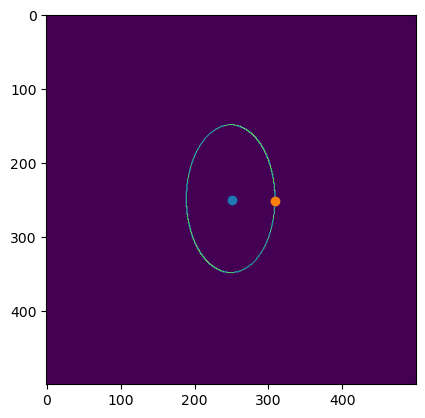

In [52]:
# Drawing ellipse1
x0 = 250; a = 60  # x center, half width                                       
y0 = 250; b = 100  # y center, half height 
X = np.linspace(0, 500,500)  # x values of interest
Y = np.linspace(0, 500,500)[:,None]  # y values of interest, as a "ellipse" array
ellipse = ((X-x0)/a)**2 + ((Y-y0)/b)**2 <= 1  # True for points inside the ellipse
ellipse = ellipse.astype(int)

contour1 = find_contours(ellipse)[0]
ellipse = np.zeros((500,500))
for i in contour1:
    y,x = int(i[0]), int(i[1])
    ellipse[y,x] = 1
plt.imshow(ellipse)
plt.scatter(250,250)
plt.scatter(x1,y1)